## Library Imports

In [1]:
# Basic Library
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
import pandas  as pd
import numpy   as np
%matplotlib inline

# EDA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Models Used
from sklearn.tree            import DecisionTreeClassifier, export_text, plot_tree
from sklearn.linear_model    import LogisticRegressionCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.dummy    import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm      import SVC

# Tensorflow Model
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.constraints import MaxNorm


#Splitting and Tuning
from sklearn.model_selection import cross_val_score, GridSearchCV

# Evaluation
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, fbeta_score

#Winsoriszation 
from scipy.stats.mstats import winsorize
from scipy import stats

In [2]:
#!pip install -U seaborn
#!pip install xlrd
#!pip3 install --upgrade pip
#!python3 -m pip install --upgrade setuptools
#!pip3 install --no-cache-dir  --force-reinstall -Iv grpcio==1.57.0
#!pip3 install --upgrade --force-reinstall scikeras

In [3]:
card_data = pd.read_excel("default of credit card clients.xls", skiprows=1)
card_data = card_data.drop('ID', axis=1)

card_data.rename(columns={'default payment next month' : 'default'},inplace=True)

#X = df.copy().drop(['default'], axis=1)
#y = df.copy()['default']

## Baseline Model

To evaluate the performance of a dummy classifier on the credit card default dataset. The dummy classifier simply predicts the uniform class in the training dataset, which in this case is "no default". Overall, the results of this evaluation show that the dummy classifier is not a very good model for predicting credit card defaults. However, it can be used as a baseline to compare the performance of other more complex models.


In [4]:
# Reporting Functions

def get_report(m_name, model, X_train, y_train, X_test, y_test):
    print('\n\n'+m_name+':')
    y_pred         = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    precision = tp / (tp + fp)
    recall    = tp / (tp + fn)
    F1        = 2 * (precision * recall) / (precision + recall)
    
    print(f'Precision:{precision:.3f}\nRecall   :{recall:.3f}\nF1 score :{F1:.3f}')
    
    print('Training Accuracy:', round(model.score(X_train, y_train),3))
    print('Test Accuracy    :',round(model.score(X_test, y_test),3))
    
    print("\n")
    
    print(classification_report(y_test, y_pred))

In [5]:
Y_base = card_data.default
X_base = card_data.drop(["default"], axis=1)
X_base.columns = X_base.columns.astype(str)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_base, Y_base, test_size=0.33)

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train_d, y_train_d)

get_report('Dummy model', dummy_clf, X_train_d, y_train_d, X_test_d, y_test_d)



Dummy model:
Precision:0.225
Recall   :0.506
F1 score :0.311
Training Accuracy: 0.501
Test Accuracy    : 0.497


              precision    recall  f1-score   support

           0       0.78      0.50      0.61      7686
           1       0.22      0.51      0.31      2214

    accuracy                           0.50      9900
   macro avg       0.50      0.50      0.46      9900
weighted avg       0.65      0.50      0.54      9900



## Exploratory Data Analysis
This code performs exploratory data analysis on the credit card default dataset. The dataset contains information on 30000 credit card holders, including their credit limit, payment history, and whether or not they defaulted on their payments.This exploratory data analysis has shown that the credit card default dataset is a valuable resource for understanding the factors that contribute to credit card defaults. The data can be used to develop models that can predict whether or not a customer is likely to default on their payments.


In [6]:
card_data.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...       3272       3455       3261         0      1000      1000   
2      0  ...      14331      14948      15549      1518      1500      1000   
3      0  ...      28314      28959      29547      2000      2019      1200   
4      0  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default  
0         0         0         0        1  
1      1000         0      2000        1  
2      1000      1000      5000        0  
3      1100      1069      1000        0  
4      9000       689       679        0  

[5 rows x 24 columns]

In [7]:
card_data.shape

(30000, 24)

In [8]:
card_data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

In [9]:
card_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

In [10]:
card_data.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

In [11]:
card_data.describe()

LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667      1.603733      1.853133      1.551867     35.485500   
std     129747.661567      0.489129      0.790349      0.521970      9.217904   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              PAY_0         PAY_2         PAY_3         PAY_4         PAY_5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.016700     -0.133767     -0.166200     -0.220667     -0.266200   
std        1.123802      1.197186      1.196868      1.169139      1.133187   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000      8.000000      8.000000      8.000000   

       ...      BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count  ...   30000.000000   30000.000000   30000.000000   30000.000000   
mean   ...   43262.948967   40311.400967   38871.760400    5663.580500   
std    ...   64332.856134   60797.155770   59554.107537   16563.280354   
min    ... -170000.000000  -81334.000000 -339603.000000       0.000000   
25%    ...    2326.750000    1763.000000    1256.000000    1000.000000   
50%    ...   19052.000000   18104.500000   17071.000000    2100.000000   
75%    ...   54506.000000   50190.500000   49198.250000    5006.000000   
max    ...  891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2      PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            PAY_AMT6       default  
count   30000.000000  30000.000000  
mean     5215.502567      0.221200  
std     17777.465775      0.415062  
min         0.000000      0.000000  
25%       117.750000      0.000000  
50%      1500.000000      0.000000  
75%      4000.000000      0.000000  
max    528666.000000      1.000000  

[8 rows x 24 columns]

default
0    23364
1     6636
Name: LIMIT_BAL, dtype: int64


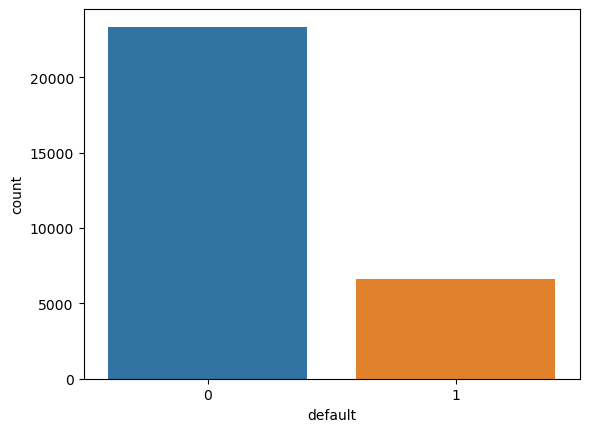

In [12]:
# Defaulters Distribution 

print(card_data.groupby('default')['LIMIT_BAL'].count())

sns.countplot(x = 'default', data = card_data)
plt.show()

## Plotting Gender, Education, Marraige

This code visualizes the relationships between gender, education, marital status, and age with credit card default in the credit card default dataset.

The count of defaulters and non-defaulters by gender shows that males are more likely to default on their credit cards than females.
The count of defaulters and non-defaulters by education level shows that people with higher levels of education are more likely to default on their credit cards than people with ower levels of education.
The count of defaulters and non-defaulters by marital status shows that married people are more likely to default on their credit cards than people who are single or divorced.
The count of defaulters and non-defaulters by age shows that people in their early 20s and 30s are more likely to default on their credit cards than people in their 40s and people in their 50s.
Overall, the visualizations show that there are a number of factors that can influence a person's likelihood of defaulting on their credit card. These factors include gender, education, marital status, and age.


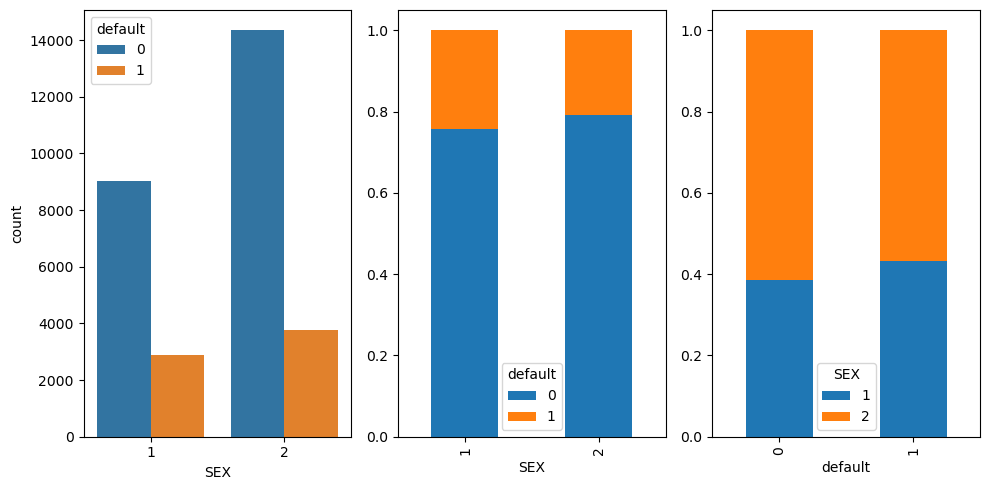

In [13]:
#payment difference between the genders
#1 = male; 2 = female

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
axes = axes.ravel()

sns.countplot(data = card_data, x = 'SEX', hue = 'default', ax=axes[0])
card_data.groupby('SEX')['default'].value_counts(normalize=True).unstack('default').plot.bar(stacked=True, ax=axes[1])
card_data.groupby('default')['SEX'].value_counts(normalize=True).unstack('SEX').plot.bar(stacked=True, ax=axes[2])

fig.tight_layout()
plt.show()

# Female defaulter is less than male

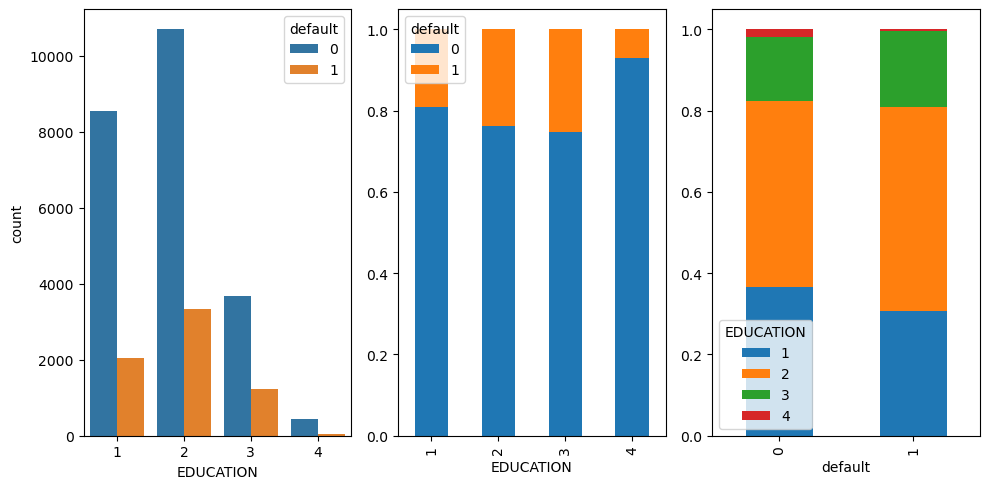

In [14]:
#payment difference between the education
#1 = graduate school; 2 = university; 3 = high school; 4 = others

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
axes = axes.ravel()

card_data = card_data.replace({'EDUCATION': [0,5,6]}, 4)

sns.countplot(data = card_data, x = 'EDUCATION', hue = 'default', ax=axes[0])
card_data.groupby('EDUCATION')['default'].value_counts(normalize=True).unstack('default').plot.bar(stacked=True, ax=axes[1])
card_data.groupby('default')['EDUCATION'].value_counts(normalize=True).unstack('EDUCATION').plot.bar(stacked=True, ax=axes[2])

fig.tight_layout()
plt.show()

# default rate is high in EDUCATION = 2,3

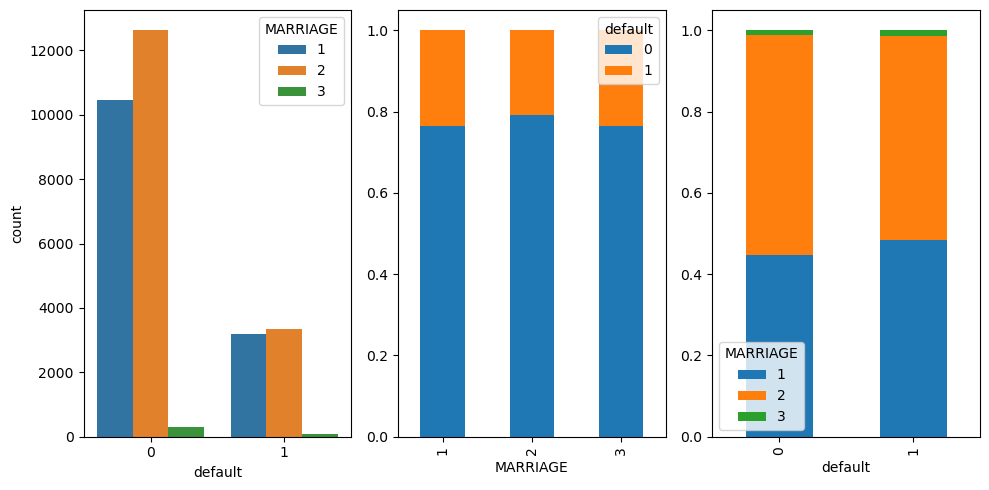

In [15]:
#payment difference between the marrige status
#1 = married; 2 = single; 3 = others

card_data = card_data.replace({'MARRIAGE': [0]}, 3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
axes = axes.ravel()

sns.countplot(data = card_data, x = 'default', hue = 'MARRIAGE', ax=axes[0])
card_data.groupby('MARRIAGE')['default'].value_counts(normalize=True).unstack('default').plot.bar(stacked=True, ax=axes[1])
card_data.groupby('default')['MARRIAGE'].value_counts(normalize=True).unstack('MARRIAGE').plot.bar(stacked=True, ax=axes[2])

fig.tight_layout()
plt.show()

# married defaulters are more than single or others

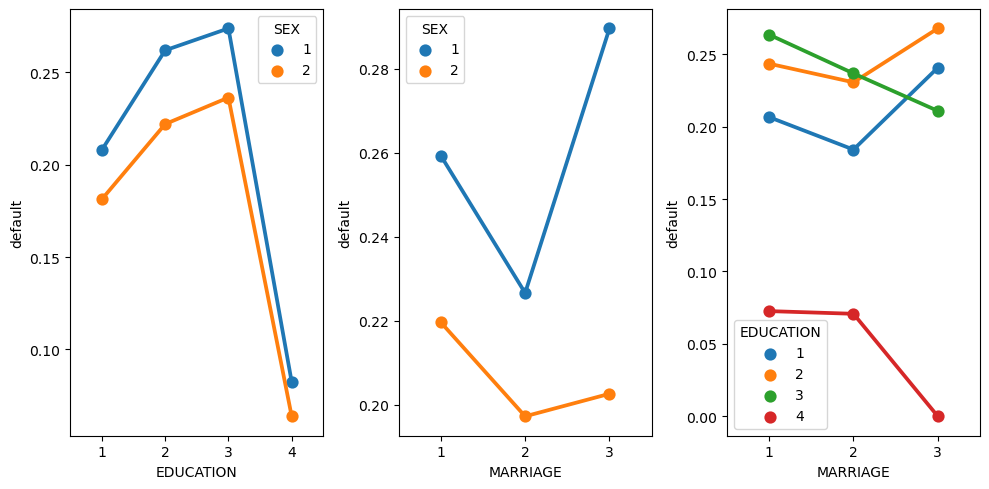

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
axes = axes.ravel()

#Payment difference between the genders with education
sns.pointplot(data = card_data, x = 'EDUCATION', y = 'default', hue = 'SEX', errorbar = None, ax=axes[0])

#Payment difference between the genders with marrige
sns.pointplot(data = card_data, x = 'MARRIAGE',  y = 'default', hue = 'SEX', errorbar = None, ax=axes[1])

#Payment difference between the education with marrige
sns.pointplot(data = card_data, x = 'MARRIAGE',  y = 'default', hue = 'EDUCATION', errorbar = None, ax=axes[2])

fig.tight_layout()
plt.show()


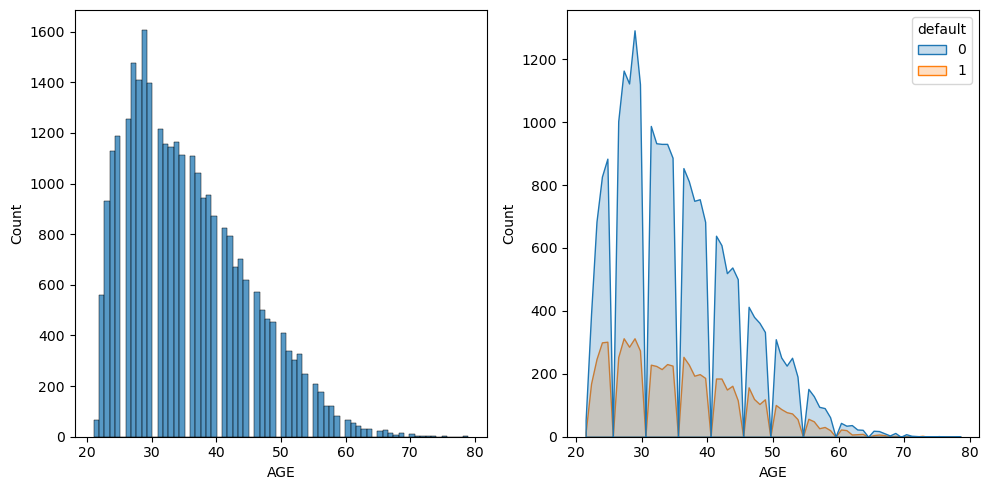

In [17]:
#Histogram - Age Distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes = axes.ravel()

sns.histplot(data = card_data, x = 'AGE', ax=axes[0])
sns.histplot(data = card_data, x = 'AGE', hue = 'default', element = 'poly', ax=axes[1])

fig.tight_layout()
plt.show()

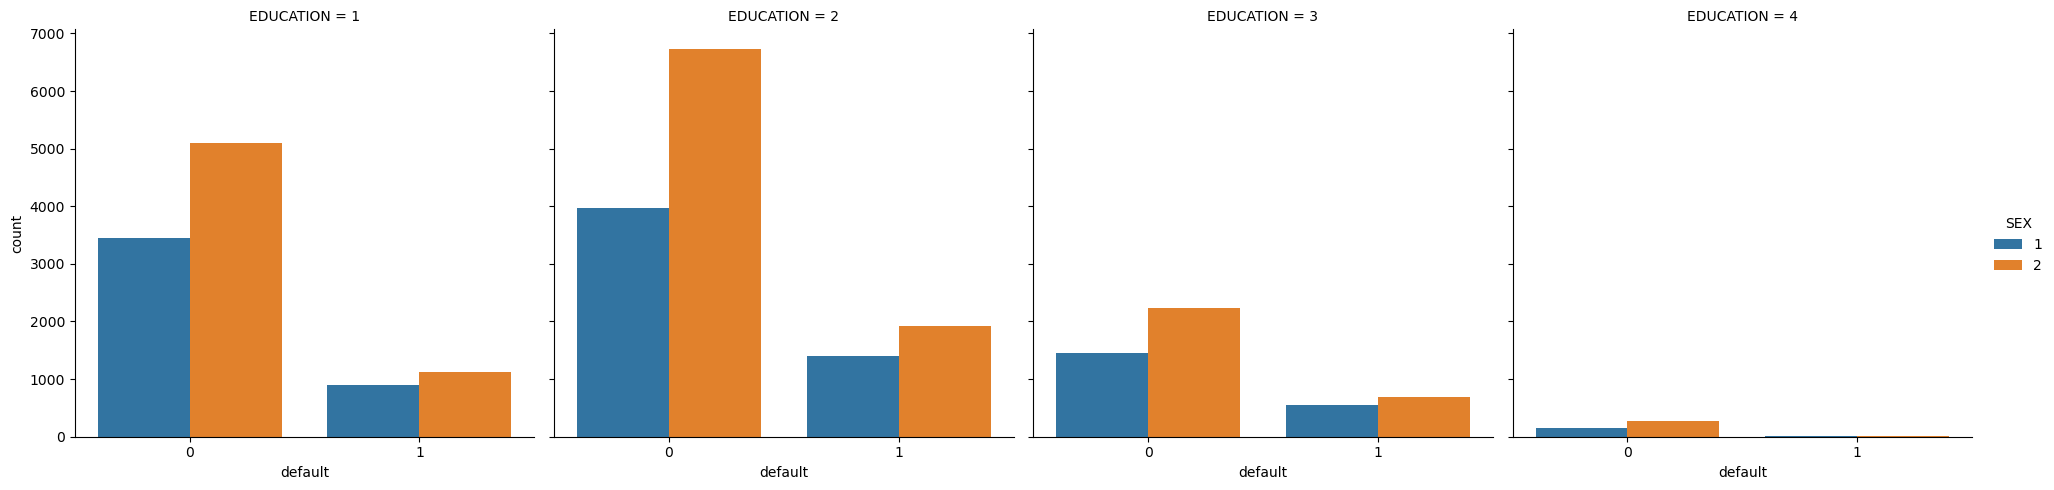

In [18]:
#payment difference between the genders with education
sns.catplot(data = card_data, x = 'default', kind = 'count', hue = 'SEX', col = 'EDUCATION')
plt.show()

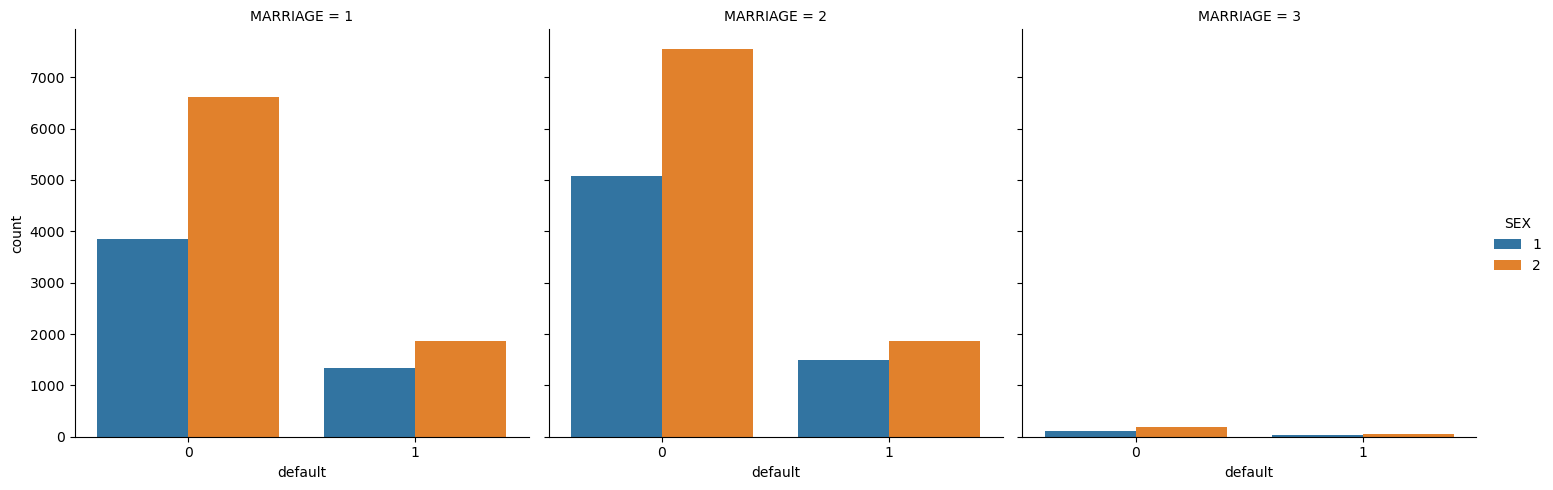

In [19]:
#payment difference between the genders with marriage
sns.catplot(data = card_data, x = 'default', kind = 'count', hue = 'SEX', col = 'MARRIAGE')
plt.show()

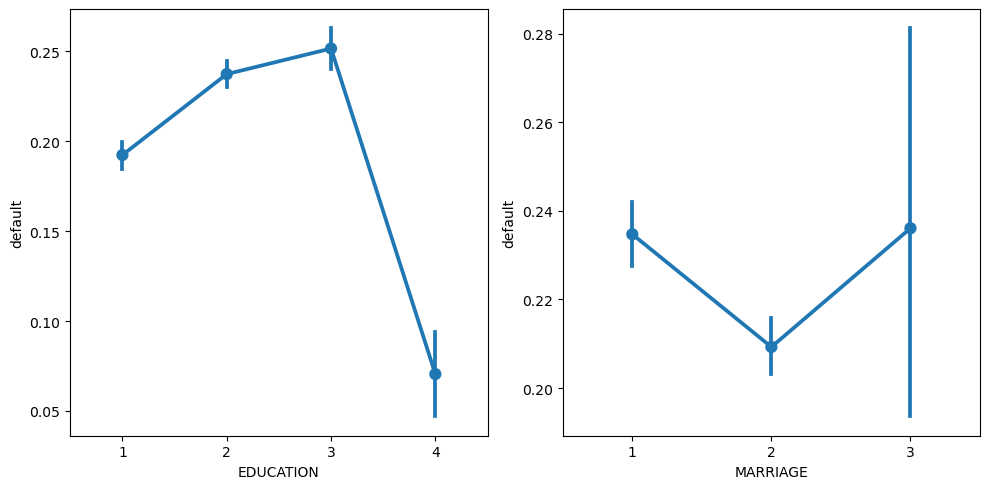

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes = axes.ravel()

sns.pointplot(data = card_data, x = 'EDUCATION', y = 'default', ax=axes[0])
sns.pointplot(data = card_data, x = 'MARRIAGE',  y = 'default', ax=axes[1])

fig.tight_layout()
plt.show()

## Plotting Limit_BAL

The histogram shows that the LIMIT_BAL variable is right-skewed. This means that there are a few people with very high credit limits, but most people have credit limits that are much lower. Also there are a few outliers in the data due to people with very high credit limits. Overall, the plots show that the LIMIT_BAL variable is not normally distributed with the mean and median not being equal and the standard deviation is large. This means that we should be careful when using statistical methods that assume normality, such as t-tests and ANOVAs. There is a relationship between credit limit and default. It shows the median credit limit for defaulters is lower than the median credit limit for non-defaulters. This suggests that people with lower credit limits are more likely to default on their credit cards. This finding is important for credit card companies to consider when making lending decisions. Winsorizing the LIMIT_BAL variable has removed some of the extreme values, which has made the distribution of the data more symmetrical, however there is still a relationship between credit limit and default. The relationship is not as strong as it was before winsorizing the variable. The scatterplots suggest that there is a relationship between age, credit limit, and default. However, the relationship is not straightforward. There are three distinct clusters of data points, and the default rate varies within each cluster. They do not show causation. It is possible that there is a third variable that is causing the correlation.


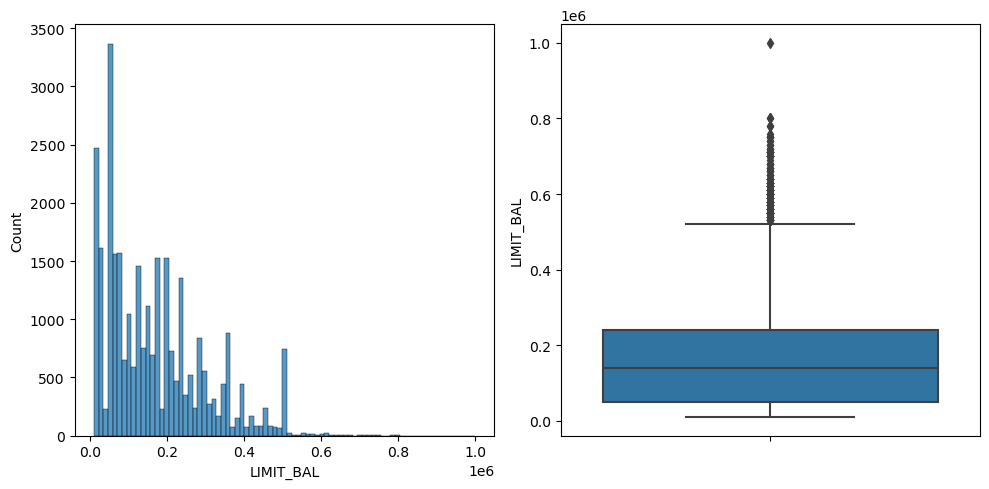

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes = axes.ravel()

sns.histplot(data = card_data, x = 'LIMIT_BAL', ax=axes[0])
sns.boxplot(data = card_data, y = 'LIMIT_BAL', ax=axes[1])

fig.tight_layout()
plt.show()

In [22]:
card_data['LIMIT_BAL'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

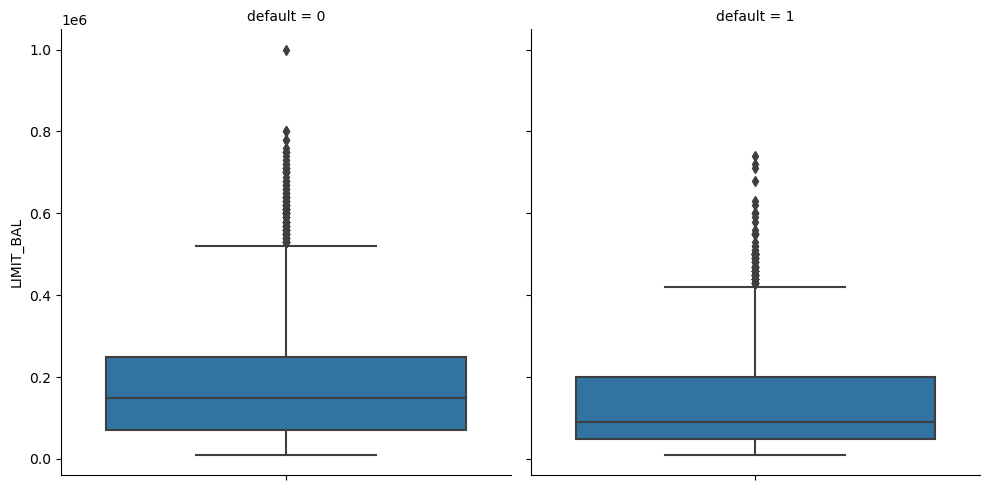

In [23]:
sns.catplot(data = card_data, y = 'LIMIT_BAL', kind = 'box', col = 'default')
plt.show()

# limit_bal of defaulters is lower

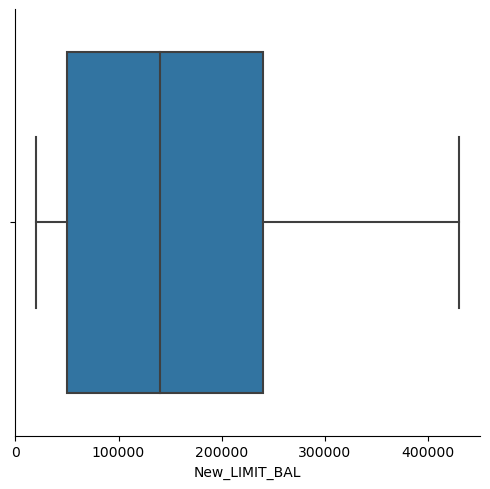

In [24]:
card_data['New_LIMIT_BAL'] = winsorize(card_data['LIMIT_BAL'], limits=[0.05, 0.05])
sns.catplot(data = card_data, x = 'New_LIMIT_BAL', kind = 'box')
plt.show()

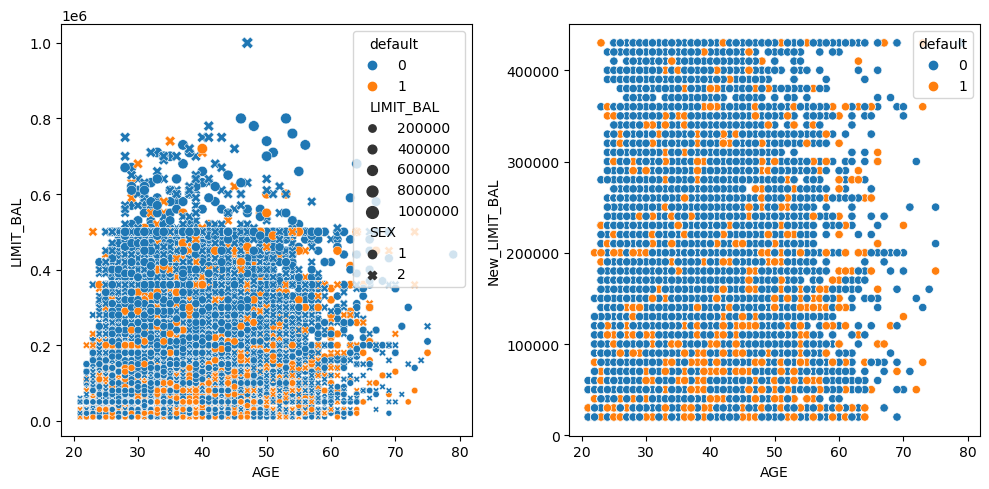

In [25]:
#Scatterplot

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes = axes.ravel()

sns.scatterplot(data = card_data, x = 'AGE', y = 'LIMIT_BAL', hue = 'default', size = 'LIMIT_BAL', style = 'SEX', ax=axes[0])
sns.scatterplot(data = card_data, x = 'AGE', y = 'New_LIMIT_BAL', hue = 'default', ax=axes[1])

fig.tight_layout()
plt.show()

card_data = card_data.drop('New_LIMIT_BAL', axis = 1)

## Plotting Bill & Pay amounts

The code first calculates the descriptive statistics for the bill_cols and pay_amount_cols variables. The code then creates boxplots for each of the bill_cols variables. The boxplots show the distribution of the bill amounts for each month. The code then creates histograms for each of the pay_amount_cols variables. The histograms show the distribution of the payment amounts for each month.


In [26]:
bill_cols = ['BILL_AMT6', 'BILL_AMT5', 'BILL_AMT4', 'BILL_AMT3', 'BILL_AMT2', 'BILL_AMT1']
pay_amount_cols = ['PAY_AMT6', 'PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
pay_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2', 'PAY_0']

In [27]:
card_data[bill_cols].describe().round(2)

BILL_AMT6  BILL_AMT5  BILL_AMT4   BILL_AMT3  BILL_AMT2  BILL_AMT1
count   30000.00   30000.00   30000.00    30000.00   30000.00   30000.00
mean    38871.76   40311.40   43262.95    47013.15   49179.08   51223.33
std     59554.11   60797.16   64332.86    69349.39   71173.77   73635.86
min   -339603.00  -81334.00 -170000.00  -157264.00  -69777.00 -165580.00
25%      1256.00    1763.00    2326.75     2666.25    2984.75    3558.75
50%     17071.00   18104.50   19052.00    20088.50   21200.00   22381.50
75%     49198.25   50190.50   54506.00    60164.75   64006.25   67091.00
max    961664.00  927171.00  891586.00  1664089.00  983931.00  964511.00

In [28]:
card_data[pay_amount_cols].describe().round(2)

PAY_AMT6   PAY_AMT5   PAY_AMT4   PAY_AMT3    PAY_AMT2   PAY_AMT1
count   30000.00   30000.00   30000.00   30000.00    30000.00   30000.00
mean     5215.50    4799.39    4826.08    5225.68     5921.16    5663.58
std     17777.47   15278.31   15666.16   17606.96    23040.87   16563.28
min         0.00       0.00       0.00       0.00        0.00       0.00
25%       117.75     252.50     296.00     390.00      833.00    1000.00
50%      1500.00    1500.00    1500.00    1800.00     2009.00    2100.00
75%      4000.00    4031.50    4013.25    4505.00     5000.00    5006.00
max    528666.00  426529.00  621000.00  896040.00  1684259.00  873552.00

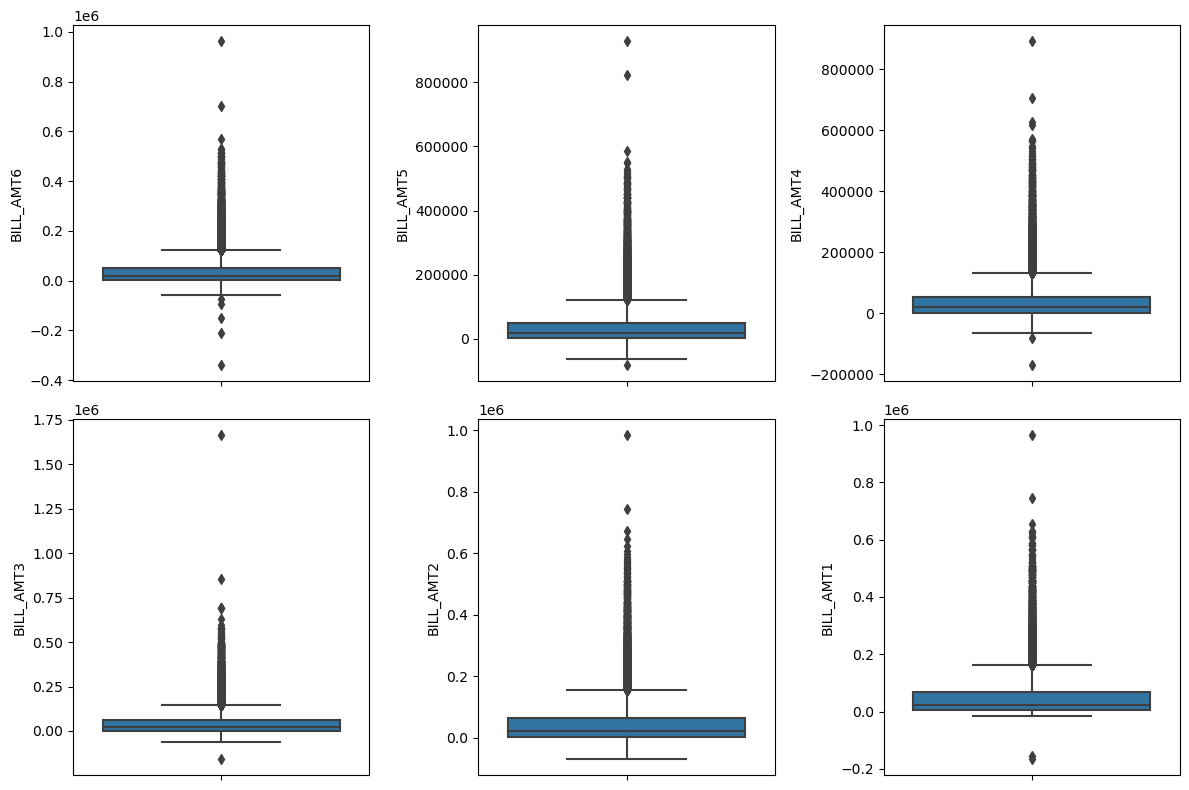

In [29]:
cols = bill_cols
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.boxplot(data = card_data, y = col, ax=ax)

fig.tight_layout()
plt.show()

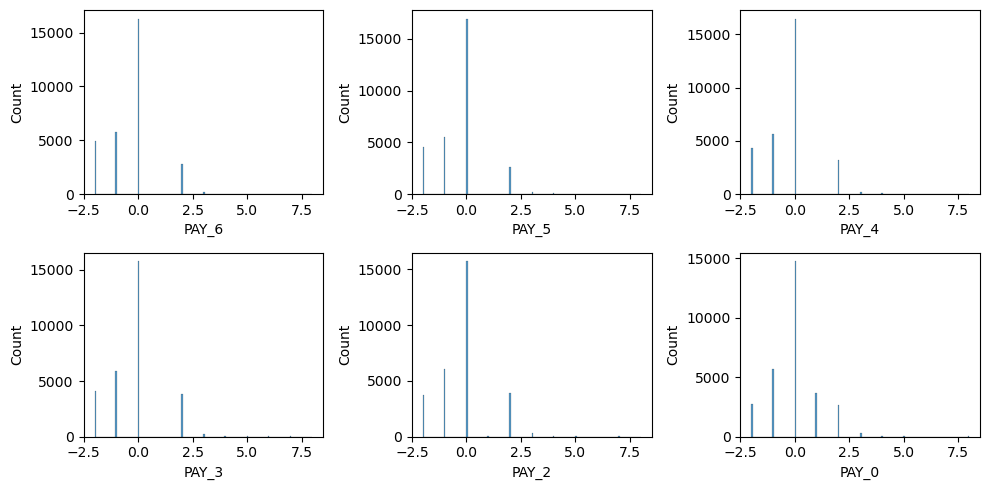

In [30]:
cols = pay_cols
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.histplot(data = card_data, x = col, ax=ax)

fig.tight_layout()
plt.show()

## Correlation

The code first creates a correlation matrix for the entire dataset. The correlation matrix shows the correlation between all of the features in the dataset. The darker the color in the heatmap, the stronger the correlation between the two features.

The code then creates correlation matrices for the bill_cols, pay_cols, and pay_amount_cols. These matrices show the correlation between the features in each of these groups.

The code then defines a function called pay_to_bill_ratio. This function calculates the ratio of the payment amount to the bill amount for each month. The ratio is rounded to 3 decimal places. If the bill amount is zero, the ratio is set to infinity.

The code then calls the pay_to_bill_ratio function to create new columns in the dataset for the payment to bill ratios. The new columns are named ratio6, ratio5, ratio4, ratio3, and ratio2.

The code then replaces all of the infinite values in the new columns with NaN. It then replaces all of the NaN values with the maximum value in each column.


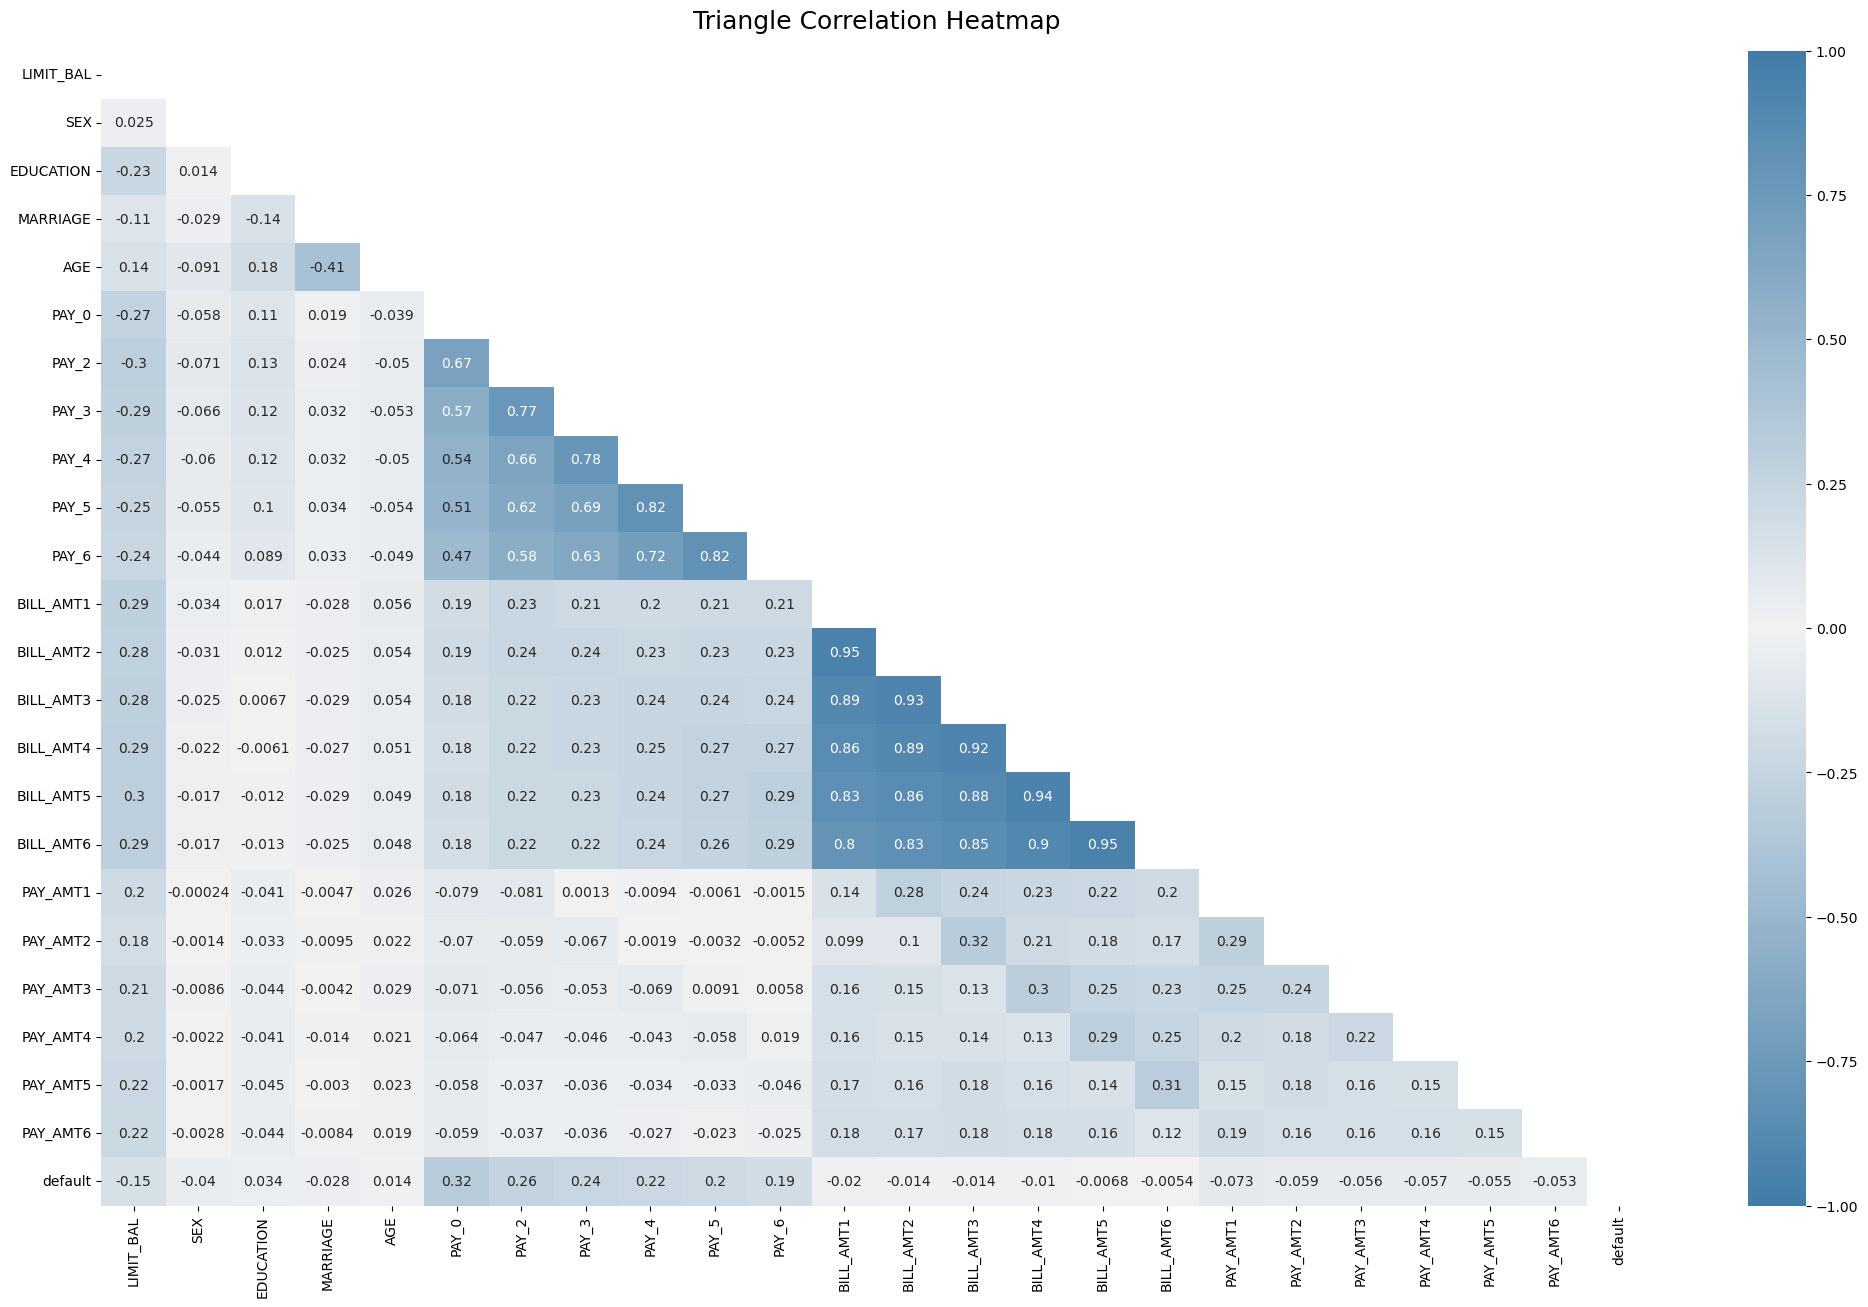

In [31]:
# Correlation Matrix
corrdf = card_data.corr()
np.triu(np.ones_like(card_data.corr()))
plt.figure(figsize=(25, 15))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(card_data.corr(), dtype=bool))
cmap = sns.diverging_palette(240,240, as_cmap=True)
heatmap = sns.heatmap(card_data.corr(), mask=mask, vmin=-1, vmax=1, cmap=cmap, annot=True)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

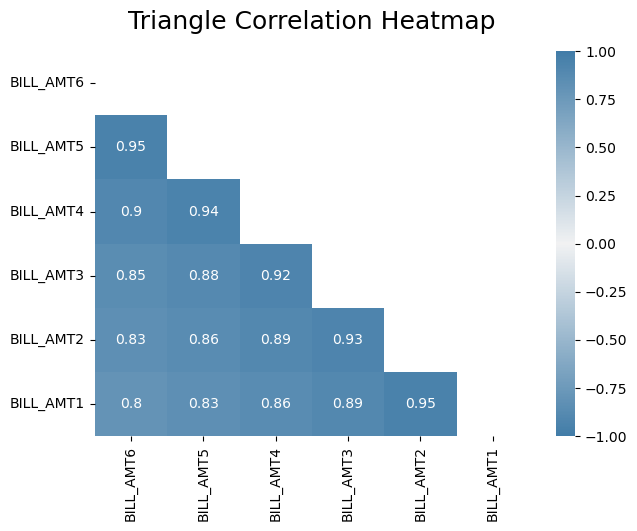

In [32]:
# bill_cols Correlation Matrix
df = card_data[bill_cols]
corrdf = df.corr()
np.triu(np.ones_like(df.corr()))
plt.figure(figsize=(7, 5))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
cmap = sns.diverging_palette(240,240, as_cmap=True)
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, cmap=cmap, annot=True)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

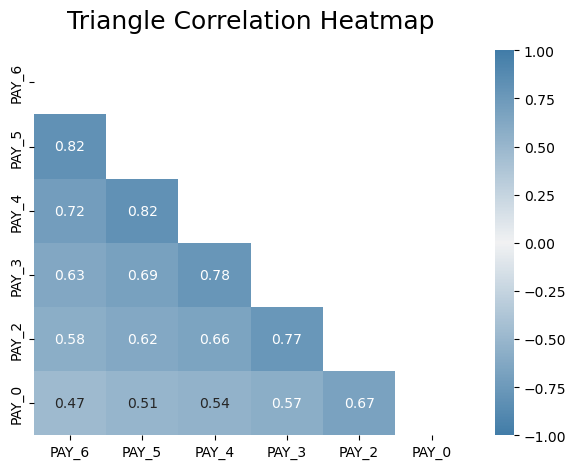

In [33]:
# pay_cols Correlation Matrix
df = card_data[pay_cols]
corrdf = df.corr()
np.triu(np.ones_like(df.corr()))
plt.figure(figsize=(7, 5))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
cmap = sns.diverging_palette(240,240, as_cmap=True)
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, cmap=cmap, annot=True)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

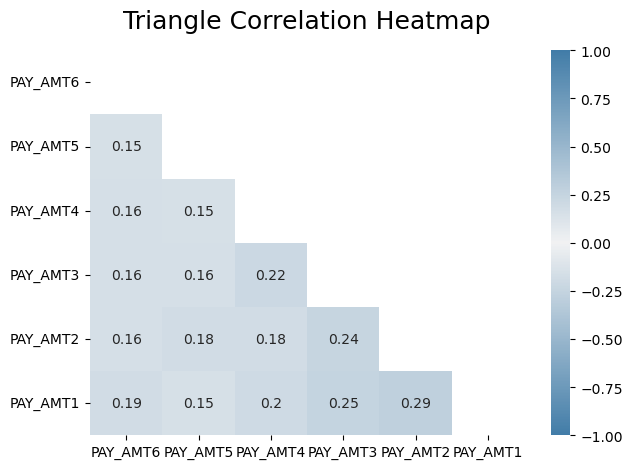

In [34]:
# pay_amount_cols Correlation Matrix
df = card_data[pay_amount_cols]
corrdf = df.corr()
np.triu(np.ones_like(df.corr()))
plt.figure(figsize=(7, 5))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
cmap = sns.diverging_palette(240,240, as_cmap=True)
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, cmap=cmap, annot=True)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [35]:
def pay_to_bill_ratio(df_):
    df = pd.DataFrame(df_)
    for month in range(6,1,-1):
        pay_amt_col = 'PAY_AMT'+str(month-1)
        bill_amt_col = 'BILL_AMT'+str(month)
        ratio_col = 'ratio'+str(month)
        df[ratio_col] = (df[pay_amt_col]/df[bill_amt_col]).round(3)
        df.loc[df[bill_amt_col] <= 0, ratio_col] = np.inf
    return df

In [36]:
ratio_cols = ['ratio6', 'ratio5', 'ratio4', 'ratio3', 'ratio2']
card_data = pay_to_bill_ratio(card_data)

for col in ratio_cols:
    card_data[col].replace(np.inf, np.nan, inplace=True)
    
for col in ratio_cols:
    mx_val = card_data[col].max()
    card_data[col].replace(np.nan, mx_val, inplace=True)

card_data[ratio_cols].head()

ratio6   ratio5    ratio4  ratio3  ratio2
0  690.655  129.705  4444.333   1.000   0.000
1    0.000    0.289     0.306   0.373   0.000
2    0.064    0.067     0.070   0.111   0.108
3    0.036    0.038     0.042   0.041   0.041
4    0.036    0.470     0.478   1.024   0.353

In [37]:
card_data.reset_index(drop=True)
card_data.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default   ratio6  \
0     -2  ...         0         0         0         0        1  690.655   
1      0  ...      1000      1000         0      2000        1    0.000   
2      0  ...      1000      1000      1000      5000        0    0.064   
3      0  ...      1200      1100      1069      1000        0    0.036   
4      0  ...     10000      9000       689       679        0    0.036   

    ratio5    ratio4  ratio3  ratio2  
0  129.705  4444.333   1.000   0.000  
1    0.289     0.306   0.373   0.000  
2    0.067     0.070   0.111   0.108  
3    0.038     0.042   0.041   0.041  
4    0.470     0.478   1.024   0.353  

[5 rows x 29 columns]

In [38]:
card_data['SEX']       = card_data['SEX'].astype('category')
card_data['MARRIAGE']  = card_data['MARRIAGE'].astype('category')
card_data['EDUCATION'] = card_data['EDUCATION'].astype('category')
encoded_df = pd.get_dummies(card_data, drop_first=True)

## PCA

The code below performs PCA on the normalized data. The PCA class from the scikit-learn library calculates the principal components of the data. The principal components are the linear combinations of the original columns that capture the most variance in the data. The code then creates a new DataFrame called pca_df that contains the principal components. This DataFrame can be used to visualize the data or to perform further analysis. Further, The code calculates the cumulative explained variance for each principal component (PC) and prints the number of PCs needed to capture 97% of the variance in the data.


In [39]:
correlated_cols = bill_cols + pay_amount_cols + ratio_cols

# Scaling
#ss = StandardScaler()
#encoded_df[correlated_cols] = pd.DataFrame(ss.fit_transform(encoded_df[correlated_cols]), columns = encoded_df[correlated_cols].columns)

# Normalisation
for i in encoded_df[correlated_cols].columns:
    encoded_df[i] = (encoded_df[i] - encoded_df[i].mean()) / encoded_df[i].std()    

pca = PCA()

pComps = pca.fit_transform(encoded_df[correlated_cols])
pca_df = pd.DataFrame(data = pComps)

In [40]:
sVar = 0
cols = list()
varc = ((pca.explained_variance_ * 100.0) / pca.explained_variance_.sum())
varc = [round(item,2) for item in varc]
for i in range(len(varc)):
    sVar += varc[i]
    cols.append("PCA_{}".format(i))
    print(i, round(sVar,2))
    if(sVar > 97):
        break
print('Columns Taken -',len(cols))

#from itertools import accumulate
#print([round(item,2) for item in list(accumulate(varc))])

0 37.31
1 53.57
2 63.17
3 68.62
4 73.88
5 79.02
6 83.64
7 88.04
8 91.79
9 94.09
10 95.93
11 97.57
Columns Taken - 12


In [41]:
pca_df.columns

RangeIndex(start=0, stop=17, step=1)

In [42]:
# Taking threshold of 97%

pca_df = pca_df.iloc[:,range(len(cols))]
pca_df.columns = cols
pca_df.head()

PCA_0     PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6  \
0 -2.839557  2.099561 -0.310672  0.684607 -0.394364  0.027118 -0.511899   
1 -1.183237 -1.450418 -0.149536  0.018632  0.029890 -0.041977  0.050735   
2 -0.697948 -1.238874 -0.181677  0.009701 -0.108828 -0.106408  0.050803   
3 -0.020905 -0.945693 -0.455178  0.077323  0.010289  0.056586 -0.033033   
4 -0.385379 -1.107415  0.860081  0.424467  0.463355  0.516865 -0.180480   

      PCA_7     PCA_8     PCA_9    PCA_10    PCA_11  
0 -0.794157 -2.271863  0.550866 -1.238869 -0.622271  
1  0.123231  0.051770  0.080112 -0.026045  0.027875  
2  0.105265  0.073379  0.073902 -0.019652  0.018379  
3  0.067764  0.070356  0.062661 -0.014430  0.001365  
4  1.000809 -0.262858  0.228772  0.022564  0.068065

In [43]:
pca_df = pd.concat([pca_df, encoded_df.drop(correlated_cols, axis=1)], axis = 1)
pca_df.head()

PCA_0     PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6  \
0 -2.839557  2.099561 -0.310672  0.684607 -0.394364  0.027118 -0.511899   
1 -1.183237 -1.450418 -0.149536  0.018632  0.029890 -0.041977  0.050735   
2 -0.697948 -1.238874 -0.181677  0.009701 -0.108828 -0.106408  0.050803   
3 -0.020905 -0.945693 -0.455178  0.077323  0.010289  0.056586 -0.033033   
4 -0.385379 -1.107415  0.860081  0.424467  0.463355  0.516865 -0.180480   

      PCA_7     PCA_8     PCA_9  ...  PAY_4  PAY_5  PAY_6  default  SEX_2  \
0 -0.794157 -2.271863  0.550866  ...     -1     -2     -2        1      1   
1  0.123231  0.051770  0.080112  ...      0      0      2        1      1   
2  0.105265  0.073379  0.073902  ...      0      0      0        0      1   
3  0.067764  0.070356  0.062661  ...      0      0      0        0      1   
4  1.000809 -0.262858  0.228772  ...      0      0      0        0      0   

   EDUCATION_2  EDUCATION_3  EDUCATION_4  MARRIAGE_2  MARRIAGE_3  
0            1            0            0           0           0  
1            1            0            0           1           0  
2            1            0            0           1           0  
3            1            0            0           0           0  
4            1            0            0           0           0  

[5 rows x 27 columns]

In [44]:
pca_df.shape

(30000, 27)

## ETL

Boxcox transformation is a power transformation that is used to transform non-normally distributed data into a normal distribution
Square root transformation is a power transformation that is used to transform skewed data into a more symmetric distribution
Log scale transformation is a power transformation that is used to transform data that has a large range of values into a more manageable scale
Finally, we selected boxcox transformation because it had the best plot



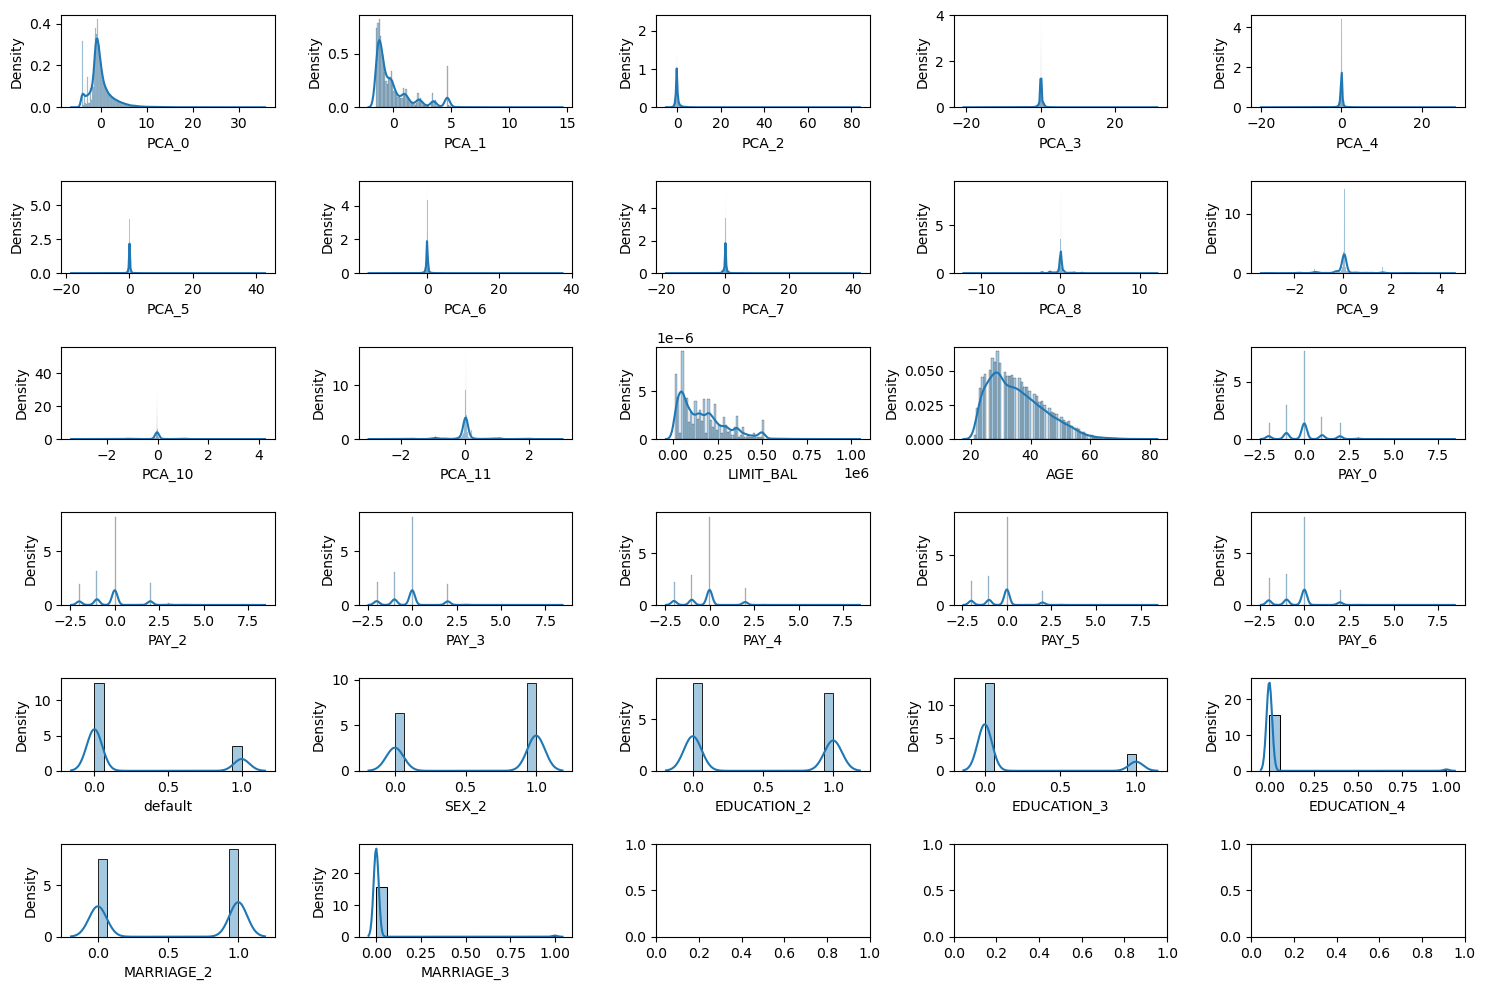

In [45]:
# select the columns to be plotted
cols = pca_df.columns

# create the figure and axes
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15,10))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.histplot(pca_df[col], stat="density", alpha=0.4, kde=True, kde_kws={"cut": 3}, ax=ax)

fig.tight_layout()
plt.show()

In [46]:
pca_df.skew()

PCA_0           1.881571
PCA_1           1.554541
PCA_2          14.815351
PCA_3          -1.566427
PCA_4          -0.800711
PCA_5           2.562129
PCA_6           5.607691
PCA_7           4.182255
PCA_8           0.339906
PCA_9          -0.115567
PCA_10          0.208503
PCA_11         -0.001411
LIMIT_BAL       0.992867
AGE             0.732246
PAY_0           0.731975
PAY_2           0.790565
PAY_3           0.840682
PAY_4           0.999629
PAY_5           1.008197
PAY_6           0.948029
default         1.343504
SEX_2          -0.424183
EDUCATION_2     0.129611
EDUCATION_3     1.815941
EDUCATION_4     7.818217
MARRIAGE_2     -0.128806
MARRIAGE_3      8.751913
dtype: float64

In [47]:
temp_df = pca_df[['AGE', 'LIMIT_BAL']].copy()

temp_df['AGE2'] = np.sqrt(temp_df['AGE'])
temp_df['AGE2'] = np.log(temp_df['AGE2'])
temp_df['AGE3'], lam = stats.boxcox(temp_df['AGE'])

temp_df['LIMIT_BAL2'] = np.sqrt(temp_df['LIMIT_BAL'])
temp_df['LIMIT_BAL3'], lam = stats.boxcox(temp_df['LIMIT_BAL'])

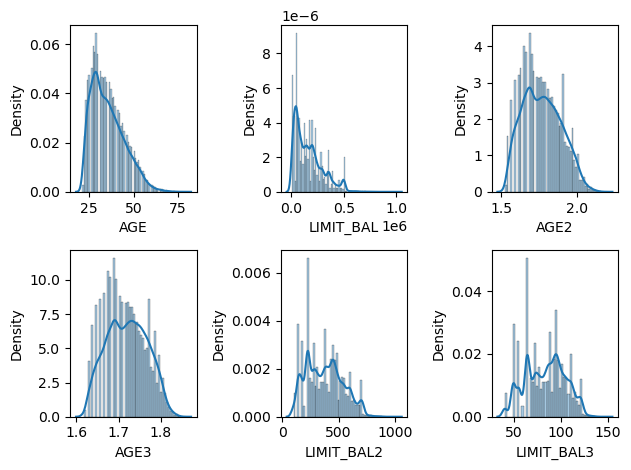

In [48]:
# select the columns to be plotted
cols = temp_df.columns

# create the figure and axes
fig, axes = plt.subplots(2, 3)
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.histplot(temp_df[col], stat="density", alpha=0.4, kde=True, kde_kws={"cut": 3}, ax=ax)

fig.tight_layout()
plt.show()

In [49]:
pca_df['AGE'], lam = stats.boxcox(pca_df['AGE'])
pca_df['LIMIT_BAL'], lam = stats.boxcox(pca_df['LIMIT_BAL'])

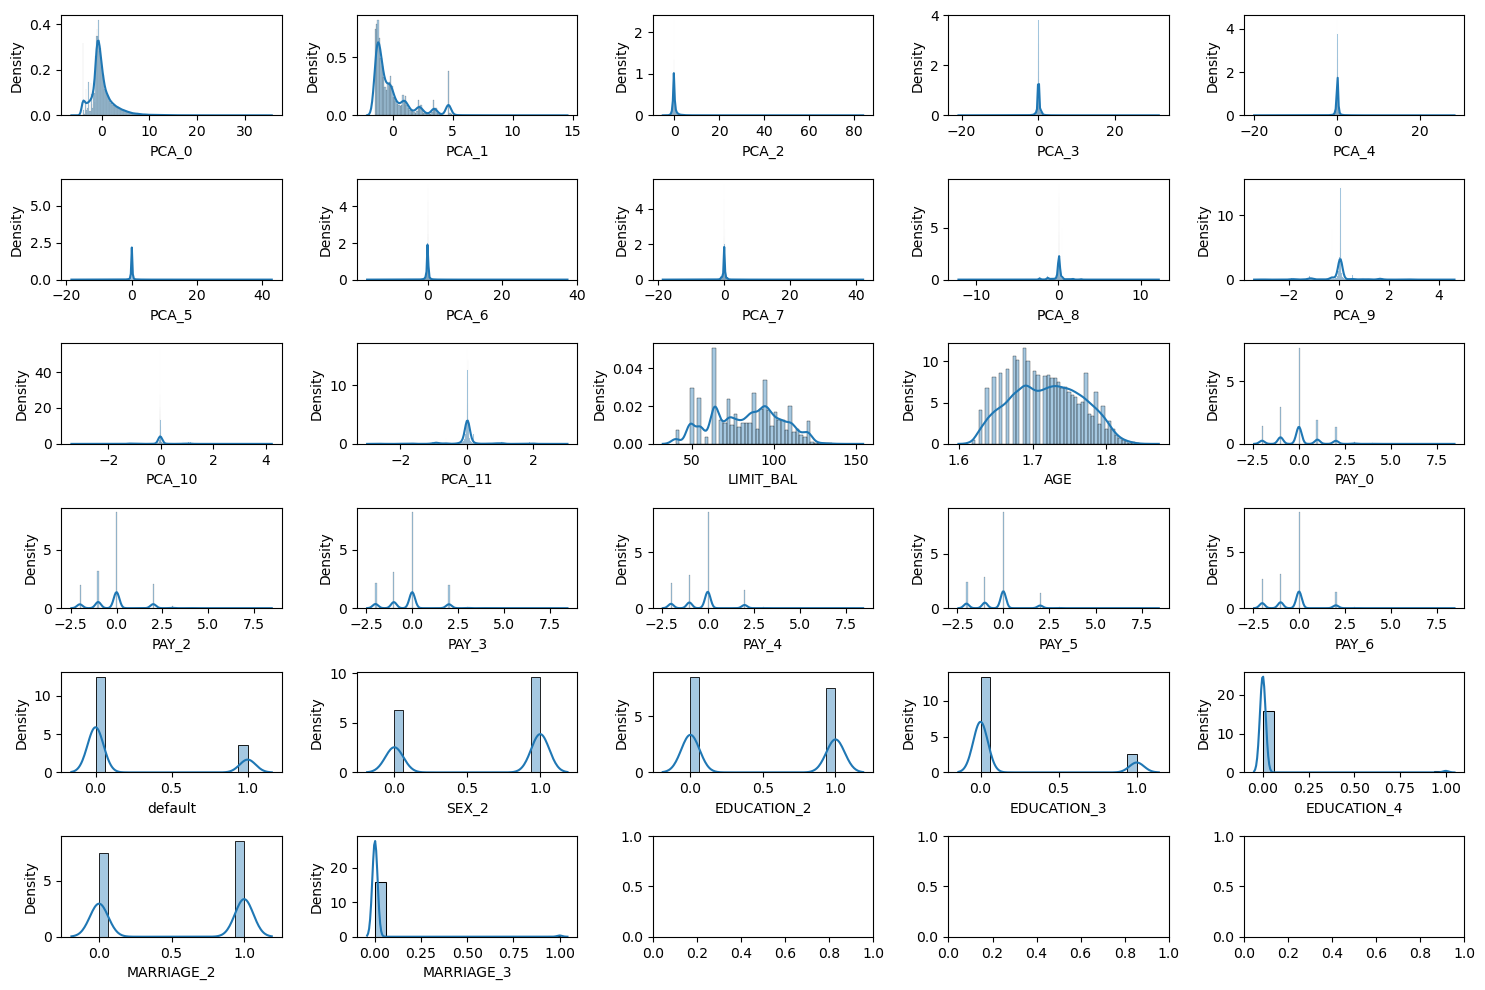

In [50]:
# select the columns to be plotted
cols = pca_df.columns

# create the figure and axes
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15,10))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.histplot(pca_df[col], stat="density", alpha=0.4, kde=True, kde_kws={"cut": 3}, ax=ax)

fig.tight_layout()
plt.show()

## Model 

here we have separated the labels (default) from the features (X) and then converted the feature column names to strings.
For model training we have split the data into training and testing sets using the train_test_split with 3:1 ratio. 

In [94]:
Y = pca_df.default
X = pca_df.drop(["default"], axis=1)
X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

print("y_train ", y_train.shape)
print("X_train ", X_train.shape)
print("y_test  ", y_test.shape)
print("X_test  ", X_test.shape)

y_train  (20100,)
X_train  (20100, 26)
y_test   (9900,)
X_test   (9900, 26)


Defined a function to print the best parameters of grid search.

In [95]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

## Logistic Rgression

now we have trained a Logistic Regression model using cross-validation, Once this code has been executed, our model will be ready for predictions 

In [96]:
lr_model = LogisticRegressionCV(max_iter = 1000)
lr_model.fit(X_train,y_train)

LogisticRegressionCV(max_iter=1000)

Now we are making predictions for test dataset, providing a comprehensive assessment of the Logistic Regression model's performance, including accuracy (80%), precision, recall, F1-score, confusion matrix, and ROC curve.

Training accuracy: 0.81
Test accuracy:     0.804

               precision    recall  f1-score   support

           0       0.82      0.97      0.88      4679
           1       0.65      0.23      0.34      1321

    accuracy                           0.80      6000
   macro avg       0.74      0.60      0.61      6000
weighted avg       0.78      0.80      0.77      6000



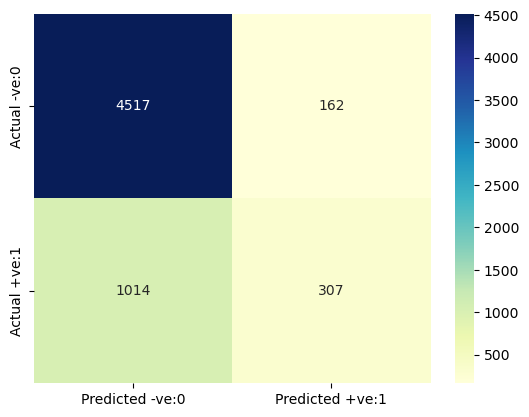



AUC -  0.7324992772157201


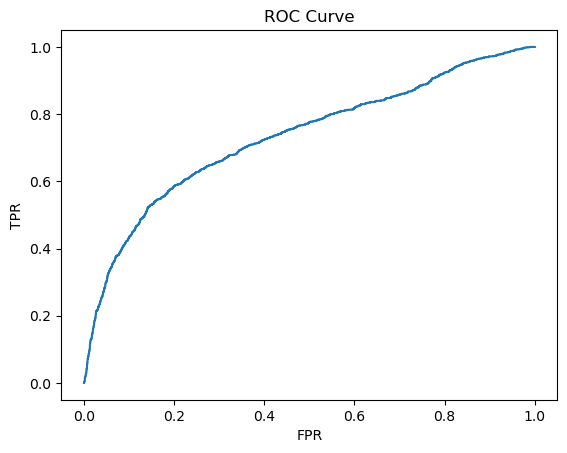

In [130]:
y_pred = lr_model.predict(X_test)

#Check the accuracy of the model
print('Training accuracy:', round(lr_model.score(X_train, y_train),3))
print('Test accuracy:    ',round(lr_model.score(X_test, y_test),3))

print('\n',classification_report(y_test, y_pred))

# visualize confusion matrix with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted -ve:0', 'Predicted +ve:1'], 
                                 index=['Actual -ve:0', 'Actual +ve:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

print('\n')
prediction_prob = lr_model.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("AUC - ",format(roc_auc))
# Plot Precision Recall curve
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

## Decision Tree

trained the decision tree

In [98]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

Training accuracy: 0.91
Test accuracy:     0.9

               precision    recall  f1-score   support

           0       0.94      0.93      0.94      4679
           1       0.77      0.78      0.78      1321

    accuracy                           0.90      6000
   macro avg       0.85      0.86      0.86      6000
weighted avg       0.90      0.90      0.90      6000



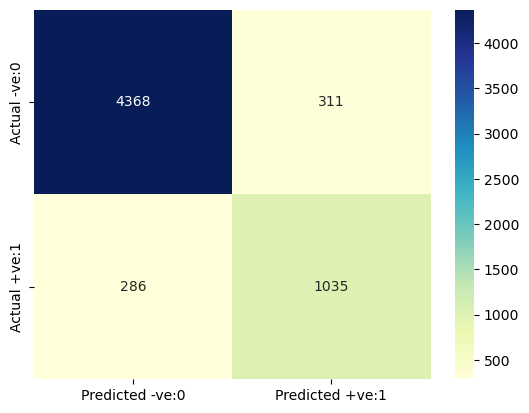



AUC -  0.8587990148454309


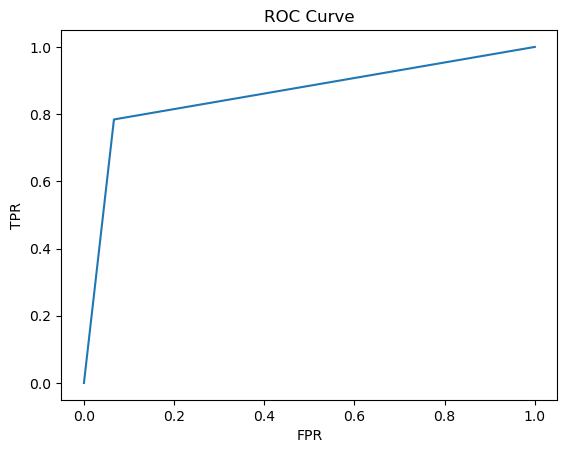

In [129]:
y_pred = dt_model.predict(X_test)

#Check the accuracy of the model
print('Training accuracy:', round(dt_model.score(X_train, y_train),3))
print('Test accuracy:    ',round(dt_model.score(X_test, y_test),3))

print('\n',classification_report(y_test, y_pred))

# visualize confusion matrix with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted -ve:0', 'Predicted +ve:1'], 
                                 index=['Actual -ve:0', 'Actual +ve:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

print('\n')
prediction_prob = dt_model.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("AUC - ",format(roc_auc))
# Plot Precision Recall curve
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

we have defined parameters for the gridsearch hyperparameter tuning

In [100]:
param_grid = {
    'max_depth': [10,20,30,40],
    'min_samples_split': [20,40,60,80,100],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01],
    'criterion':['gini','entropy']
}

 trained the grid search model

In [101]:
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state = 1),
                         param_grid,
                         cv = 5,
                         n_jobs = -1)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, 40],
                         'min_impurity_decrease': [0, 0.0005, 0.001, 0.005,
                                                   0.01],
                         'min_samples_split': [20, 40, 60, 80, 100]})

printed the result of each model in gridsearch

In [102]:
print_results(gridsearch)

BEST PARAMS: {'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0.005, 'min_samples_split': 20}

0.805 (+/-0.008) for {'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 20}
0.806 (+/-0.007) for {'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 40}
0.808 (+/-0.009) for {'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 60}
0.809 (+/-0.009) for {'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 80}
0.809 (+/-0.008) for {'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 100}
0.817 (+/-0.009) for {'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0.0005, 'min_samples_split': 20}
0.817 (+/-0.009) for {'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0.0005, 'min_samples_split': 40}
0.817 (+/-0.009) for {'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0.0

 printed the best model results, and parameters for that model

In [103]:
print('initial score:', gridsearch.best_score_)
print('initial parameters:', gridsearch.best_params_)

initial score: 0.8170149253731344
initial parameters: {'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0.005, 'min_samples_split': 20}


In [104]:
param_grid = {
    'max_depth': [8, 9, 10, 11, 12],
    'min_samples_split': [80,90,100,110,120],
    'min_impurity_decrease': [0.005, 0.01, 0.015, 0.02],
    'criterion':['entropy']
}

In [105]:
#Run Gridsearch
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state = 1),
                         param_grid,
                         cv = 5,
                         n_jobs = -1)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['entropy'],
                         'max_depth': [8, 9, 10, 11, 12],
                         'min_impurity_decrease': [0.005, 0.01, 0.015, 0.02],
                         'min_samples_split': [80, 90, 100, 110, 120]})

In [106]:
print_results(gridsearch)

BEST PARAMS: {'criterion': 'entropy', 'max_depth': 8, 'min_impurity_decrease': 0.005, 'min_samples_split': 80}

0.817 (+/-0.006) for {'criterion': 'entropy', 'max_depth': 8, 'min_impurity_decrease': 0.005, 'min_samples_split': 80}
0.817 (+/-0.006) for {'criterion': 'entropy', 'max_depth': 8, 'min_impurity_decrease': 0.005, 'min_samples_split': 90}
0.817 (+/-0.006) for {'criterion': 'entropy', 'max_depth': 8, 'min_impurity_decrease': 0.005, 'min_samples_split': 100}
0.817 (+/-0.006) for {'criterion': 'entropy', 'max_depth': 8, 'min_impurity_decrease': 0.005, 'min_samples_split': 110}
0.817 (+/-0.006) for {'criterion': 'entropy', 'max_depth': 8, 'min_impurity_decrease': 0.005, 'min_samples_split': 120}
0.817 (+/-0.006) for {'criterion': 'entropy', 'max_depth': 8, 'min_impurity_decrease': 0.01, 'min_samples_split': 80}
0.817 (+/-0.006) for {'criterion': 'entropy', 'max_depth': 8, 'min_impurity_decrease': 0.01, 'min_samples_split': 90}
0.817 (+/-0.006) for {'criterion': 'entropy', 'max_dep

In [107]:
print('second score:', gridsearch.best_score_)
print('second parameters:', gridsearch.best_params_)

second score: 0.8170149253731344
second parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_impurity_decrease': 0.005, 'min_samples_split': 80}


In [108]:
gridsearch.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.005,
 'min_samples_leaf': 1,
 'min_samples_split': 80,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

Retrieving the Best Estimator, Plotting the Decision Tree

In [109]:
bestCtree = gridsearch.best_estimator_

fig = plt.figure(figsize=(20,20), dpi = 600)
_ = plot_tree(bestCtree, 
                   feature_names=list(X.columns),  
                   class_names=['Not Retained', 'Retained'],
                   filled=True, max_depth=5)

## Random Classifier

training the random classifier

In [110]:
print("\nRandom Forest Classifier Model")
rfc = RandomForestClassifier(random_state = 3, criterion='gini', n_estimators = 300, min_samples_leaf = 150, max_features = 10)
rfc.fit(X_train, y_train)


Random Forest Classifier Model


RandomForestClassifier(max_features=10, min_samples_leaf=150, n_estimators=300,
                       random_state=3)

here too we are checking model performance.

Training accuracy: 0.822
Test accuracy:     0.815

               precision    recall  f1-score   support

           0       0.84      0.94      0.89      4679
           1       0.64      0.36      0.46      1321

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.80      0.81      0.79      6000



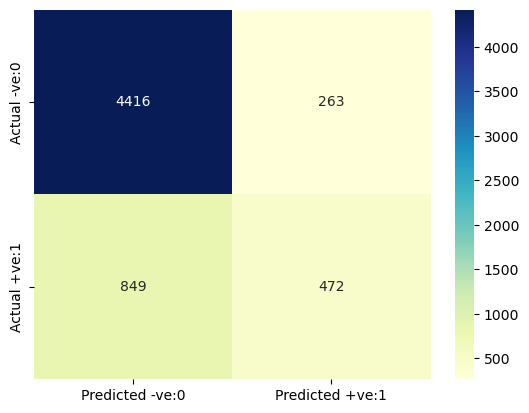



AUC -  0.7829082833262605


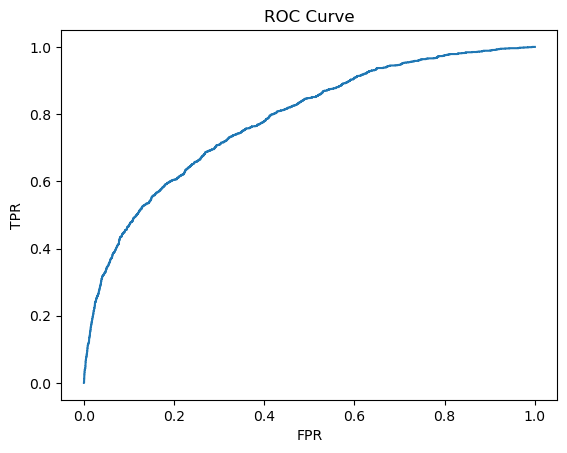

In [131]:
y_pred = rfc.predict(X_test)

#Check the accuracy of the model
print('Training accuracy:', round(rfc.score(X_train, y_train),3))
print('Test accuracy:    ',round(rfc.score(X_test, y_test),3))

print('\n',classification_report(y_test, y_pred))

# visualize confusion matrix with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted -ve:0', 'Predicted +ve:1'], 
                                 index=['Actual -ve:0', 'Actual +ve:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

print('\n')
# Plot Precision Recall curve
prediction_prob = rfc.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("AUC - ", format(roc_auc))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

Calculating Feature Importance and Displaying the Plot.

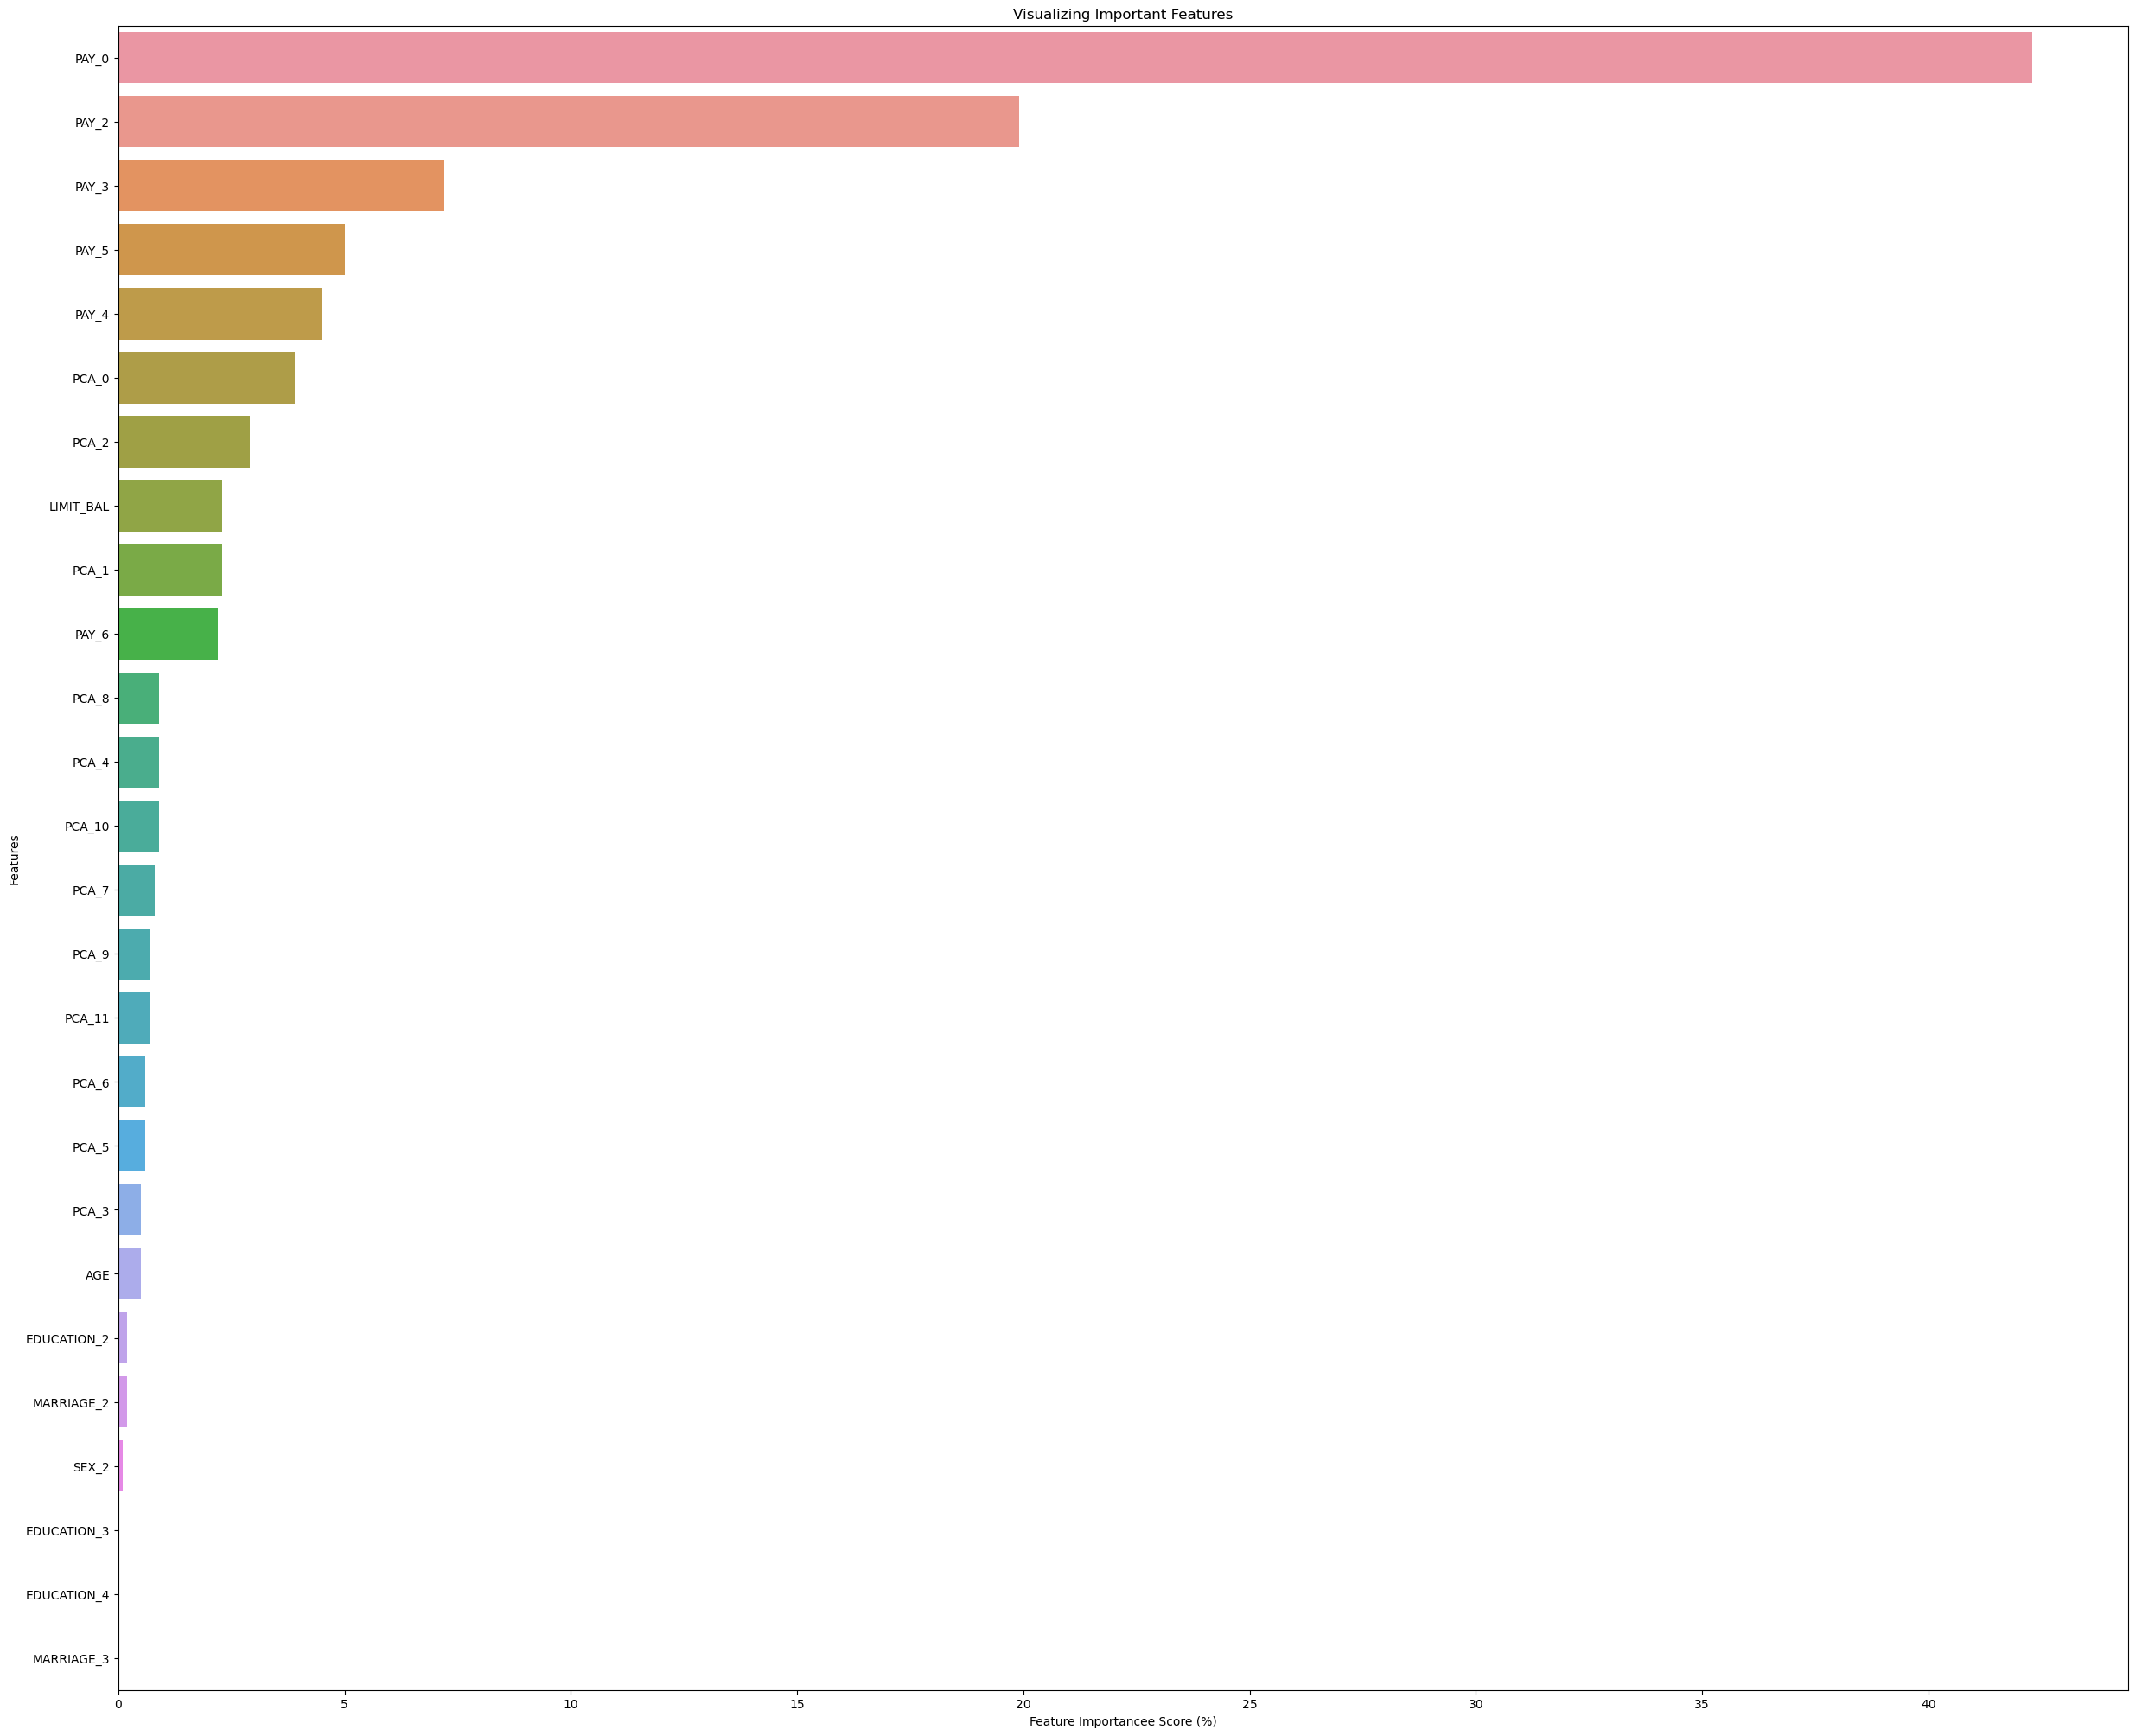

In [112]:
## Features Importance
feature_imp = pd.DataFrame({'Feature': list(X_train),'Importance': rfc.feature_importances_}).sort_values('Importance', ascending = False)
feature_imp['Importance'] = feature_imp['Importance'] * 100
feature_imp['Importance'] = feature_imp['Importance'].round(1)
# Creating a bar plot
plt.figure(figsize=(30, 25))
sns.barplot(x=feature_imp['Importance'], y=feature_imp.Feature)
# Add labels to your graph
plt.xlabel('Feature Importancee Score (%)')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## Adaboost

using GridSearchCV to perform hyperparameter tuning for an AdaBoostClassifier. 

In [113]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)
abc = AdaBoostClassifier(estimator=DecisionTreeClassifier())
pipe = Pipeline(steps=[('ada_boost', abc)])

n_components = [8]

base_estimator__max_depth = [i for i in range(3,8,2)]

parameters = dict(
                  ada_boost__estimator__max_depth=base_estimator__max_depth,
                 )

clf_GS = GridSearchCV(pipe, parameters, scoring=ftwo_scorer)
clf_GS.fit(X_train, y_train)

#print('Best Number #Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(clf_GS.best_estimator_.get_params()['ada_boost'])
print(clf_GS.best_params_)
print(clf_GS.best_score_)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5))
{'ada_boost__estimator__max_depth': 5}
0.3961391617534413


here we are checking model performance.

Training accuracy: 0.842

               precision    recall  f1-score   support

           0       0.87      0.94      0.90      4679
           1       0.69      0.50      0.58      1321

    accuracy                           0.84      6000
   macro avg       0.78      0.72      0.74      6000
weighted avg       0.83      0.84      0.83      6000



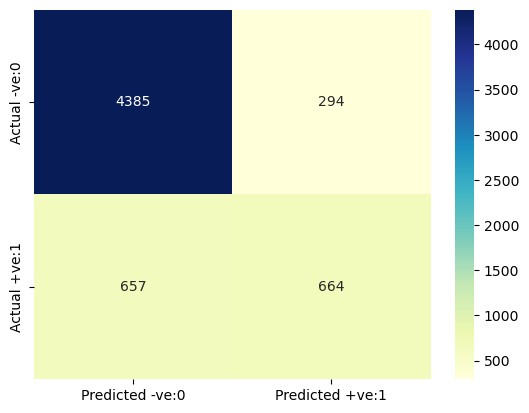



AUC -  0.8472072861185458


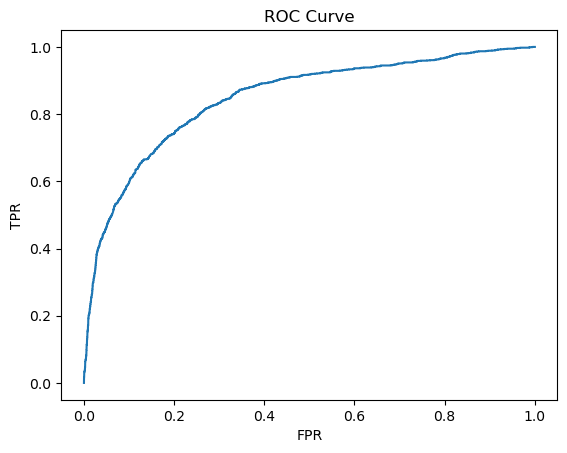

In [132]:
y_pred = clf_GS.predict(X_test)

#Check the accuracy of the model
accScore = accuracy_score(y_test, y_pred)
print('Training accuracy:', round(accScore,3))

print('\n',classification_report(y_test, y_pred))

# visualize confusion matrix with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted -ve:0', 'Predicted +ve:1'], 
                                  index=['Actual -ve:0', 'Actual +ve:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

print('\n')
# Plot Precision Recall curve
prediction_prob = clf_GS.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("AUC - ", format(roc_auc))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

## Neural Network

In this code, a Multi-Layer Perceptron (MLP) classifier is trained using the training data.

In [115]:
mlp1 = MLPClassifier(random_state=42)
mlp1.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(mlp1.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp1.score(X_test, y_test)))

Accuracy on training set: 0.82
Accuracy on test set: 0.82


In this code, an MLP classifier with a maximum of 1000 iterations and a random seed of 
42 is trained, 


In [116]:
mlp2 = MLPClassifier(max_iter=1000, random_state=42)
mlp2.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(mlp2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp2.score(X_test, y_test)))

Accuracy on training set: 0.822
Accuracy on test set: 0.823


This code trains an MLP classifier with a maximum of 1000 iterations, regularization strength (alpha) of 1, and a random seed of 42, 

In [117]:
mlp3 = MLPClassifier(max_iter=1000, alpha=1, random_state=42)
mlp3.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(mlp3.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp3.score(X_test, y_test)))

Accuracy on training set: 0.816
Accuracy on test set: 0.823


here we are checking the model performance

Training accuracy: 0.819
Test accuracy:     0.815

               precision    recall  f1-score   support

           0       0.83      0.96      0.89      4679
           1       0.67      0.31      0.42      1321

    accuracy                           0.81      6000
   macro avg       0.75      0.63      0.66      6000
weighted avg       0.80      0.81      0.79      6000



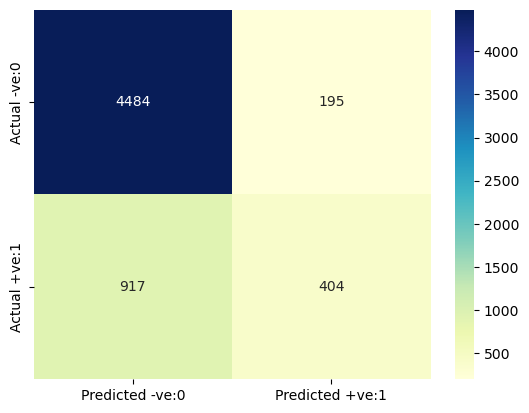



AUC -  0.7595687012322846


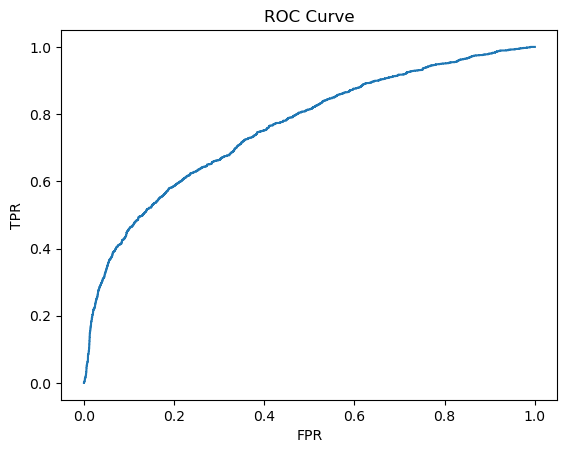

In [133]:
y_pred = mlp3.predict(X_test)

#Check the accuracy of the model
print('Training accuracy:', round(mlp3.score(X_train, y_train),3))
print('Test accuracy:    ',round(mlp3.score(X_test, y_test),3))

print('\n',classification_report(y_test, y_pred))

# visualize confusion matrix with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted -ve:0', 'Predicted +ve:1'], 
                                 index=['Actual -ve:0', 'Actual +ve:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

print('\n')
# Plot Precision Recall curve
prediction_prob = mlp3.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("AUC - ", format(roc_auc))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

## SVM

we are training the SVM model

In [119]:
svc1 = SVC(C=1000, random_state=42, probability=True)
svc1.fit(X_train, y_train)

SVC(C=1000, probability=True, random_state=42)

Checking the svm model performance

Training accuracy: 0.816
Test accuracy:     0.812

               precision    recall  f1-score   support

           0       0.83      0.96      0.89      4679
           1       0.66      0.30      0.41      1321

    accuracy                           0.81      6000
   macro avg       0.75      0.63      0.65      6000
weighted avg       0.79      0.81      0.78      6000



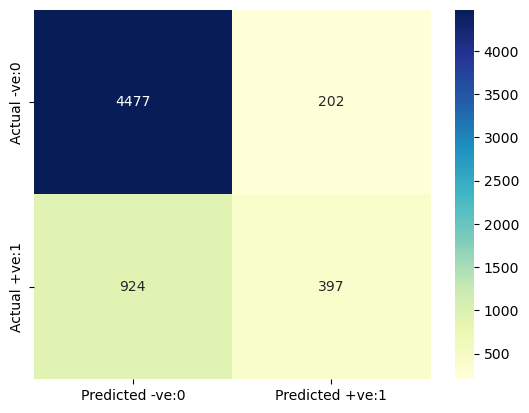



AUC -  0.7139210921800323


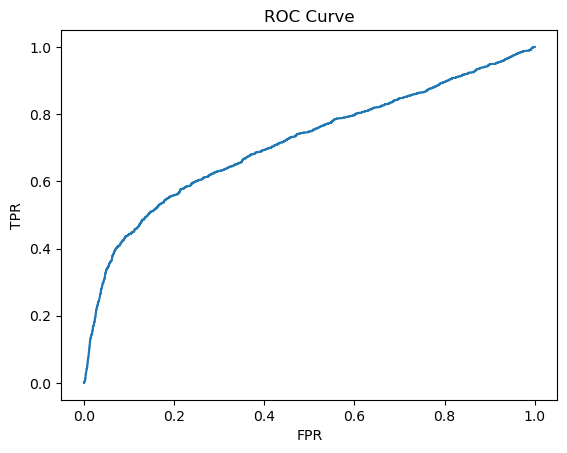

In [134]:
y_pred = svc1.predict(X_test)

#Check the accuracy of the model
print('Training accuracy:', round(svc1.score(X_train, y_train),3))
print('Test accuracy:    ',round(svc1.score(X_test, y_test),3))

print('\n',classification_report(y_test, y_pred))

# visualize confusion matrix with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted -ve:0', 'Predicted +ve:1'], 
                                 index=['Actual -ve:0', 'Actual +ve:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

print('\n')
# Plot Precision Recall curve
prediction_prob = svc1.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("AUC - ", format(roc_auc))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

## Gradient Boosting

## in this code, a Gradient Boosting Classifier is instantiated with a random seed of 42 and then trained on the training data.

In [121]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

here we are checking the gradient boost model performance.

Training accuracy: 0.827
Test accuracy:     0.818

               precision    recall  f1-score   support

           0       0.84      0.95      0.89      4679
           1       0.66      0.36      0.47      1321

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000



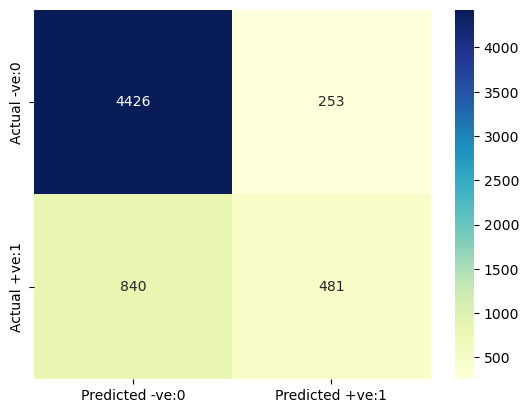



AUC -  0.7831110026777398


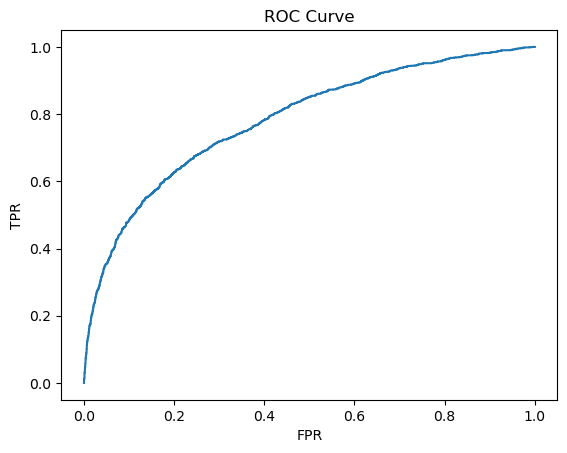

In [135]:
y_pred = gb.predict(X_test)

#Check the accuracy of the model
print('Training accuracy:', round(gb.score(X_train, y_train),3))
print('Test accuracy:    ',round(gb.score(X_test, y_test),3))

print('\n',classification_report(y_test, y_pred))

# visualize confusion matrix with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted -ve:0', 'Predicted +ve:1'], 
                                 index=['Actual -ve:0', 'Actual +ve:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

print('\n')
# Plot Precision Recall curve
prediction_prob = gb.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("AUC - ", format(roc_auc))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

## Summary

here we are comparing the # model performance of all models. Accuracy and f1 score for decision tree is best. So we will select this model. 

In [125]:
algorithms = ["Dummy model", "Logistic Regression", "Decision Trees", "Random Forest", "Gradient Boosting", "Support Vector Machine", "Deep Learning"]

get_report('Dummy model',           dummy_clf, X_train_d, y_train_d, X_test_d, y_test_d)
get_report('Logistic Regression',   lr_model,  X_train, y_train, X_test, y_test)
get_report('Decision Trees',        dt_model,  X_train, y_train, X_test, y_test)
get_report('Random Forest',         rfc,       X_train, y_train, X_test, y_test)
get_report('Gradient Boosting',     gb,        X_train, y_train, X_test, y_test)
get_report('Support Vector Machine',svc1,      X_train, y_train, X_test, y_test)
get_report('Deep Learning',         mlp3,      X_train, y_train, X_test, y_test)


tests_accuracy = [dummy_clf.score(X_test_d, y_test_d), lr_model.score(X_test, y_test), dt_model.score(X_test, y_test),
                 rfc.score(X_test, y_test), gb.score(X_test, y_test), svc1.score(X_test, y_test),
                 mlp3.score(X_test, y_test)]

compare_algorithms = pd.DataFrame({ "Algorithms": algorithms, "Tests Accuracy": tests_accuracy })
compare_algorithms.sort_values(by = "Tests Accuracy", ascending = False)



Dummy model:
Precision:0.223
Recall   :0.495
F1 score :0.308
Training Accuracy: 0.506
Test Accuracy    : 0.495


              precision    recall  f1-score   support

           0       0.78      0.50      0.61      7686
           1       0.22      0.49      0.31      2214

    accuracy                           0.50      9900
   macro avg       0.50      0.50      0.46      9900
weighted avg       0.65      0.50      0.54      9900



Logistic Regression:
Precision:0.655
Recall   :0.232
F1 score :0.343
Training Accuracy: 0.81
Test Accuracy    : 0.804


              precision    recall  f1-score   support

           0       0.82      0.97      0.88      4679
           1       0.65      0.23      0.34      1321

    accuracy                           0.80      6000
   macro avg       0.74      0.60      0.61      6000
weighted avg       0.78      0.80      0.77      6000



Decision Trees:
Precision:0.769
Recall   :0.783
F1 score :0.776
Training Accuracy: 0.91
Test Accuracy    : 

Algorithms  Tests Accuracy
2          Decision Trees        0.900500
4       Gradient Boosting        0.817833
3           Random Forest        0.814667
6           Deep Learning        0.814667
5  Support Vector Machine        0.812333
1     Logistic Regression        0.804000
0             Dummy model        0.501111